In [1]:
import time
import traceback
from pathlib import Path
from typing import List, Tuple

from mpase import (
    mpase,
    CfgCommon, CfgHDR, CfgPF, CfgMorph,
    view_single,   # <= per-label visualization (no overlay)
)



=== chr1 ===
[RUN] chr1: 6 CSVs
[VIEW] chr1: levels=[100, 98, 95, 90], planes=('XY', 'YZ', 'XZ')
  => chr1_12hrs_untr


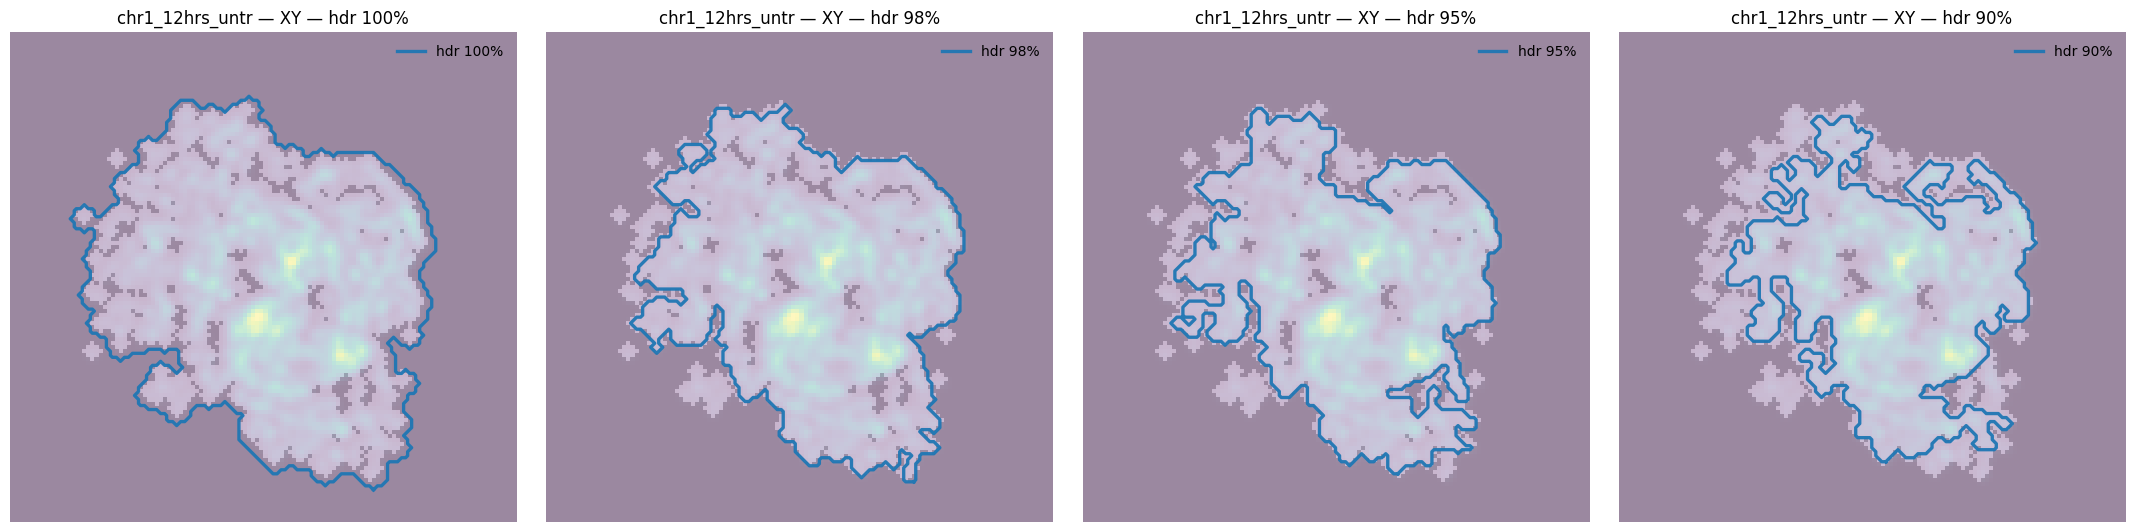

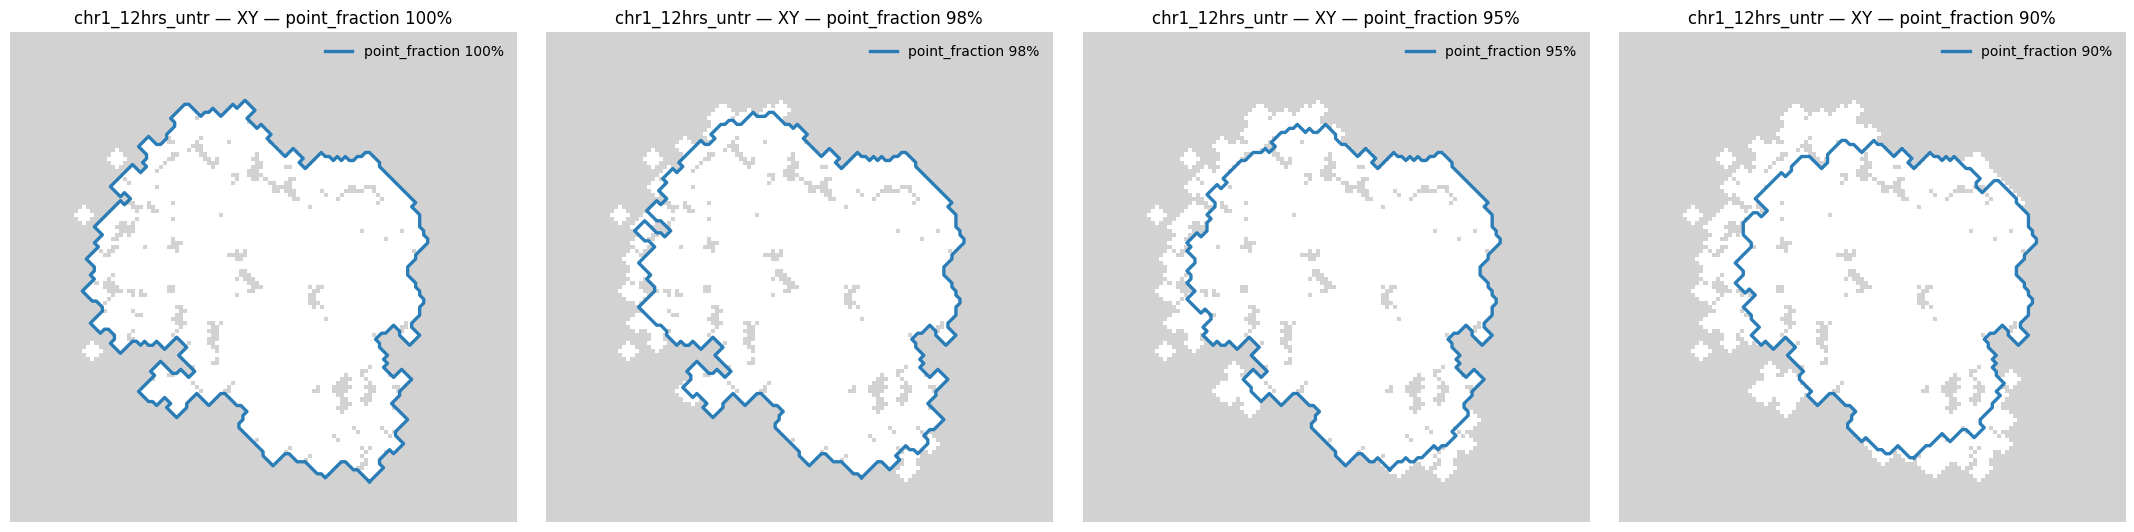

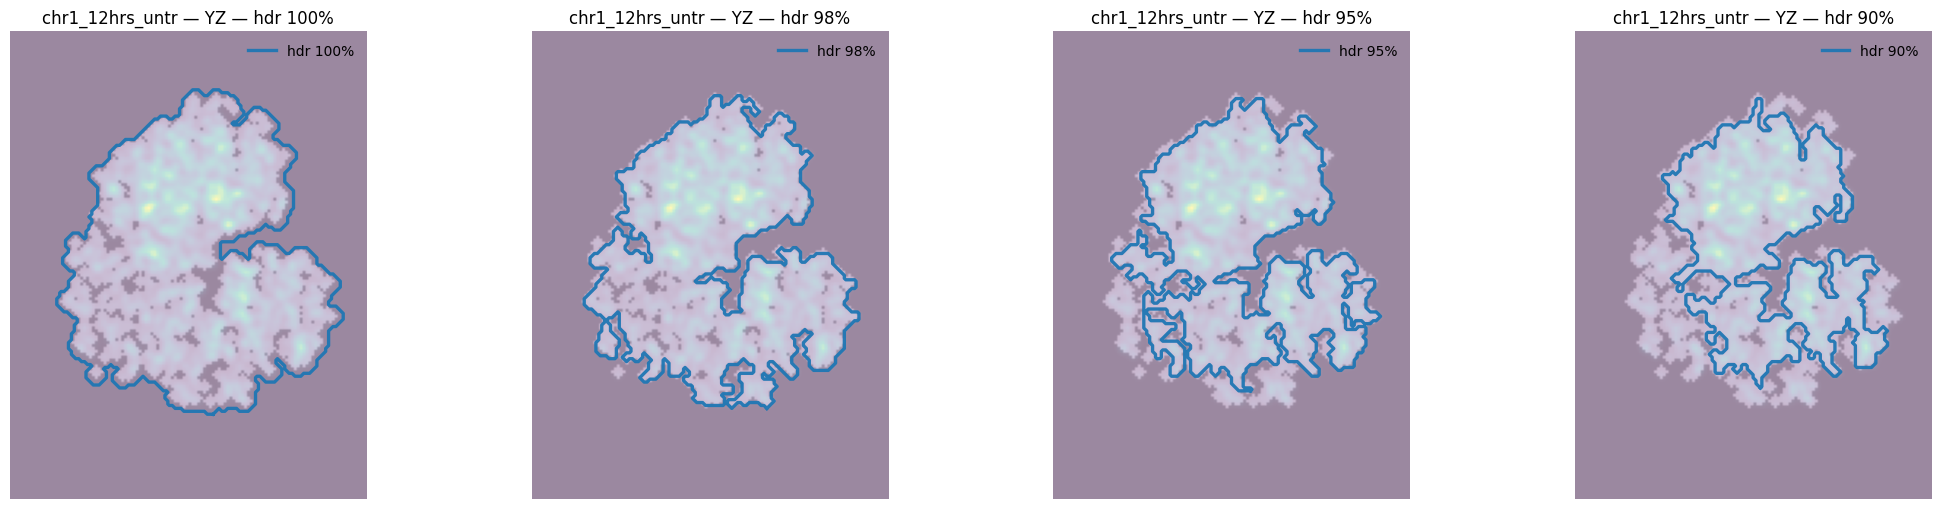

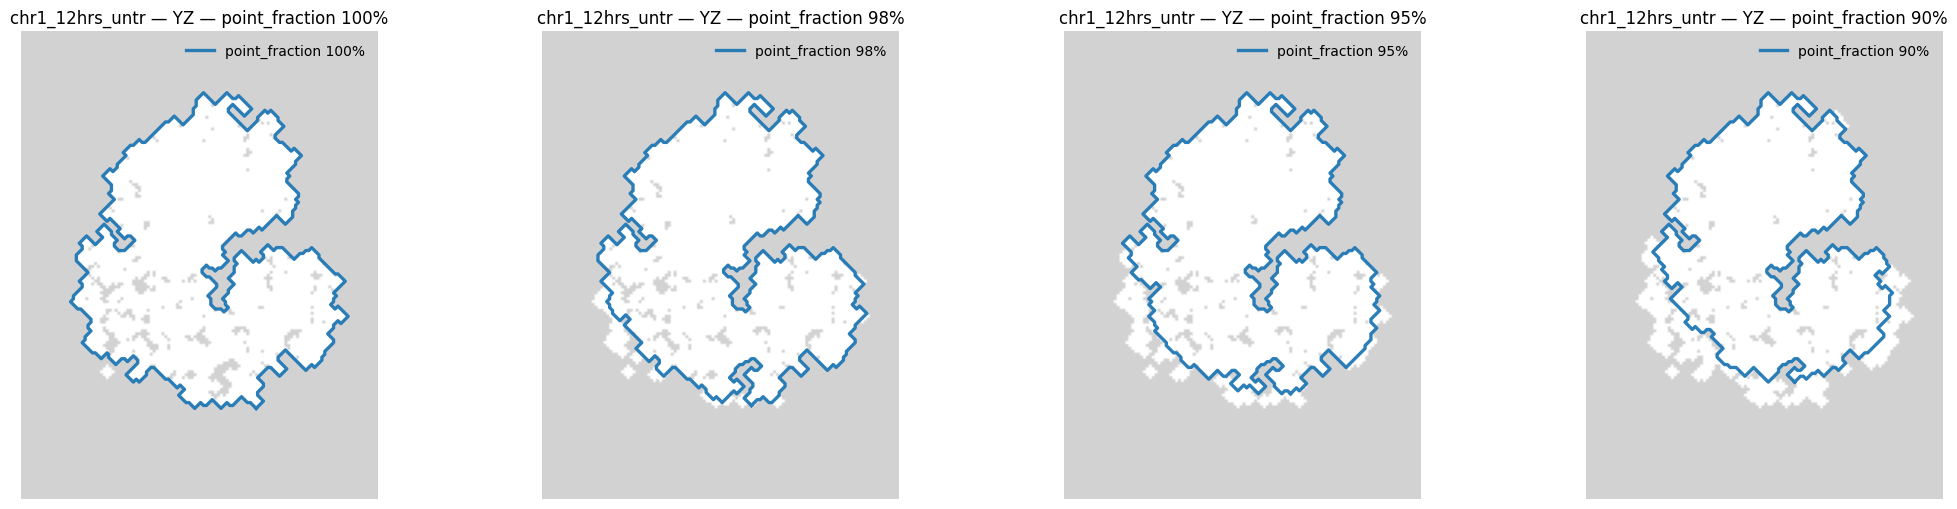

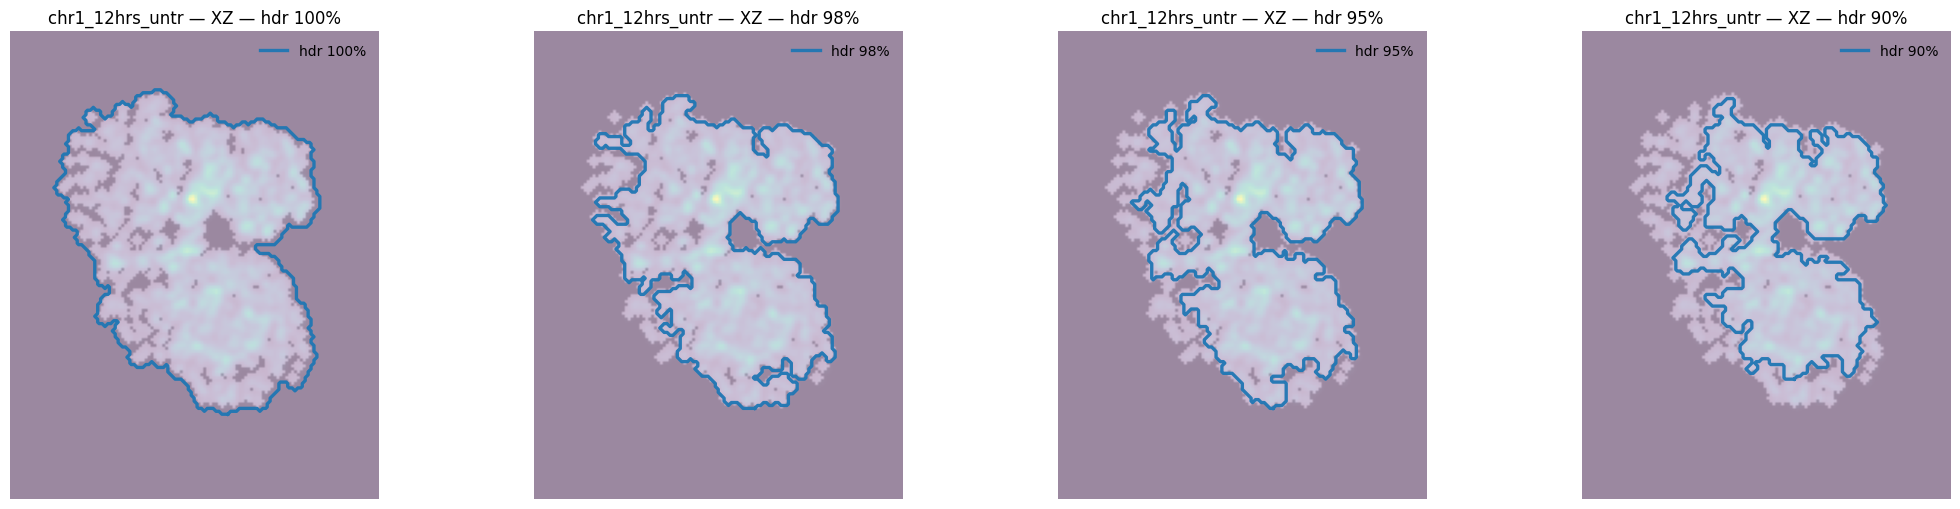

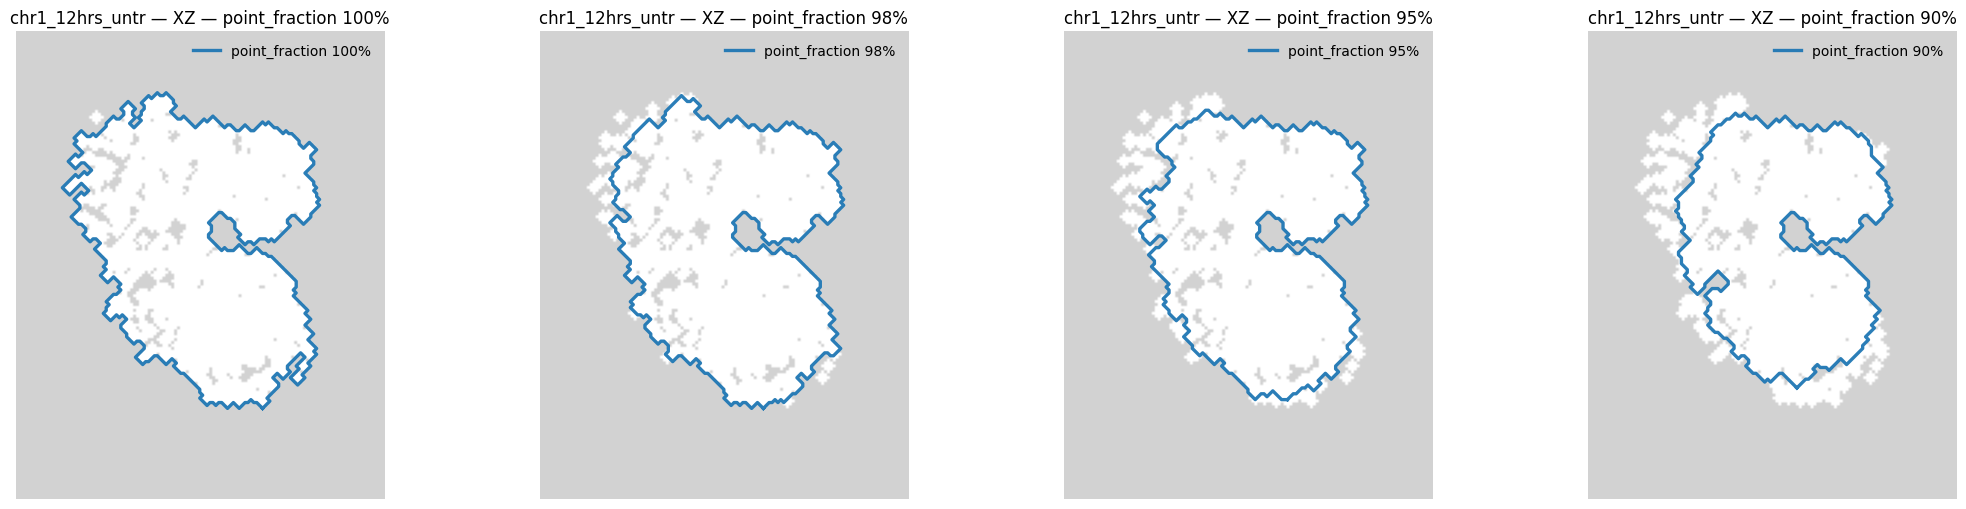

  => chr1_12hrs_vacv


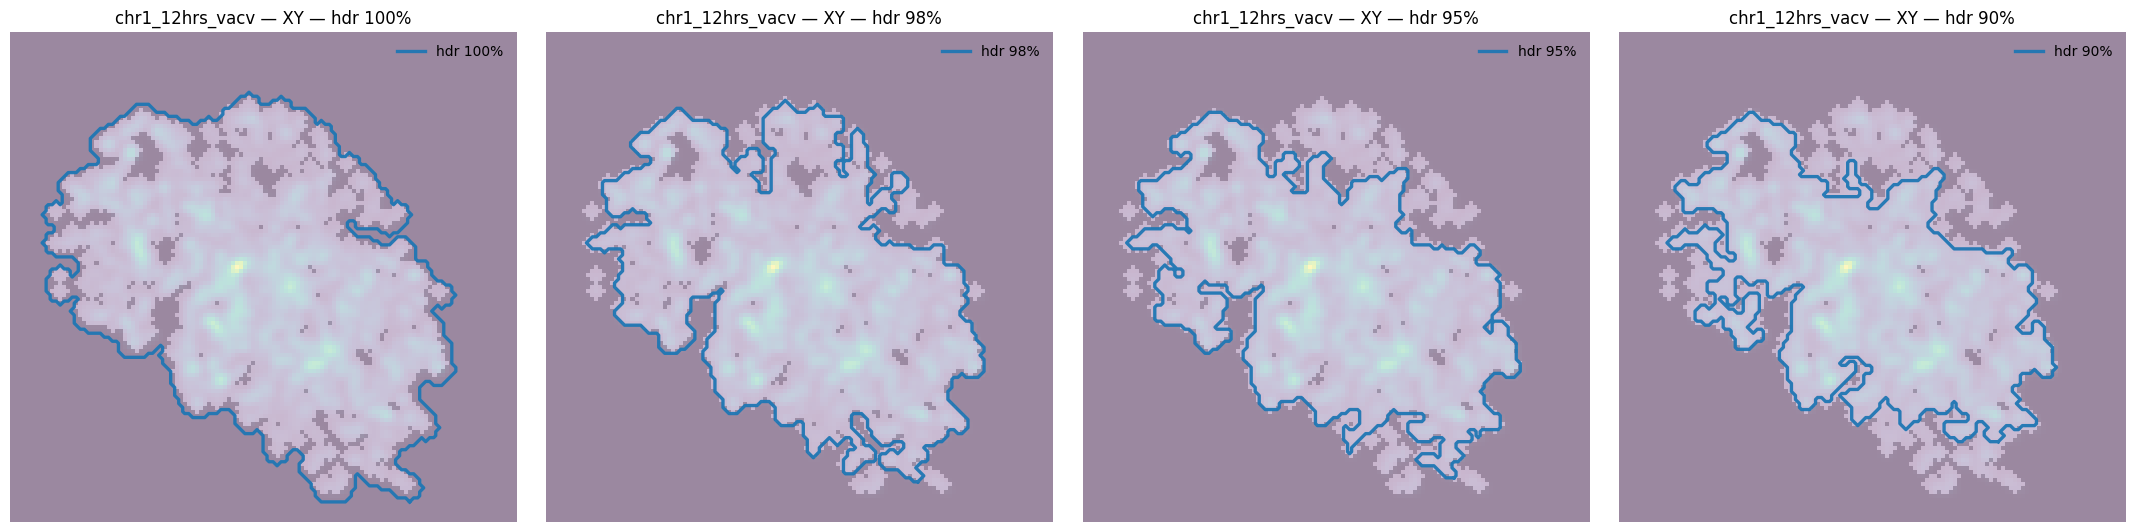

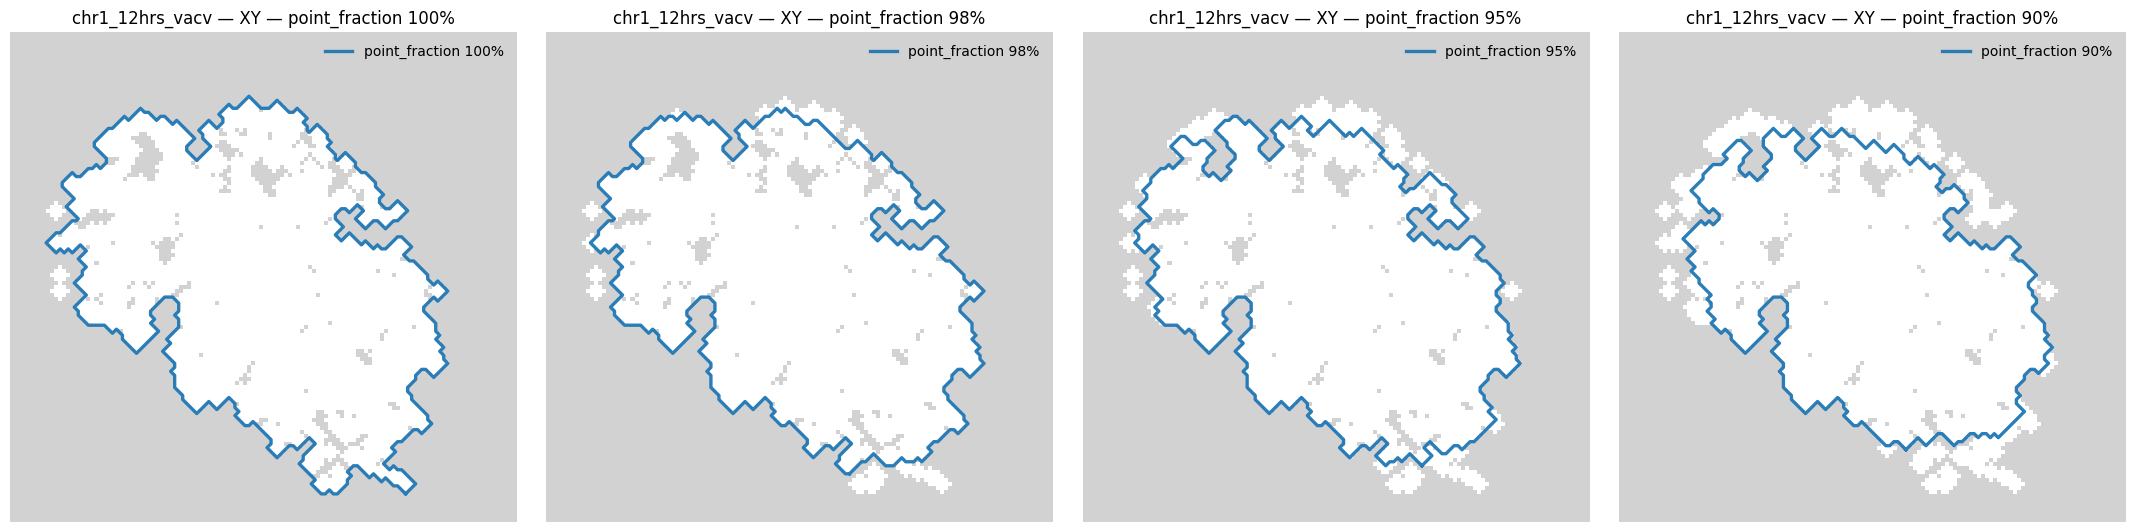

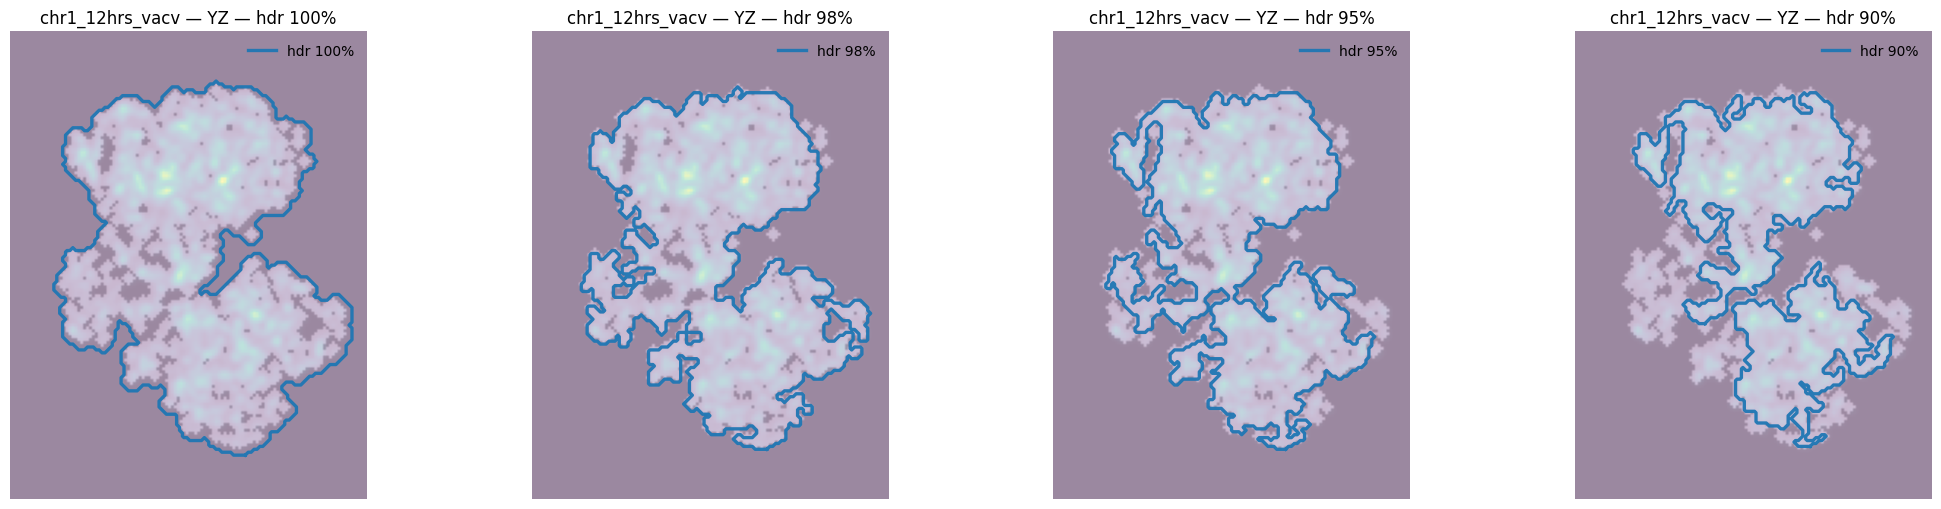

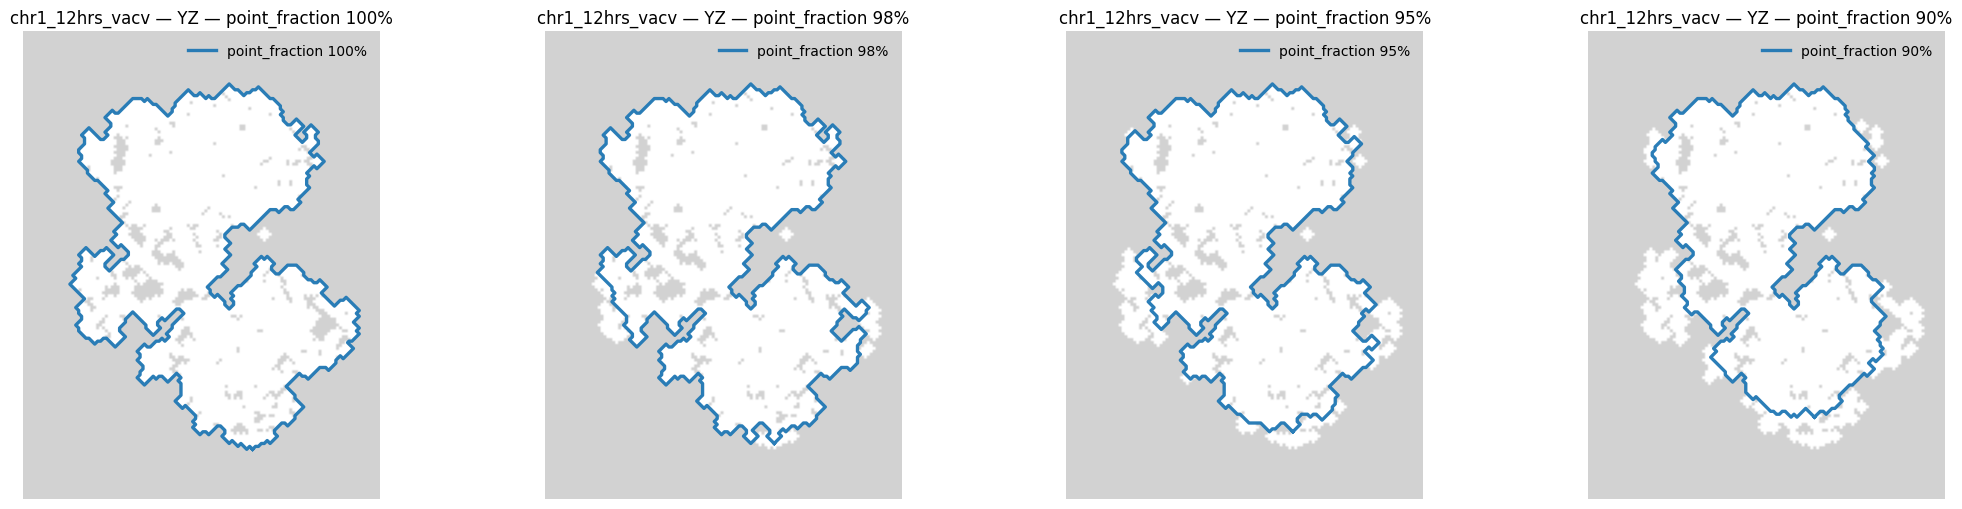

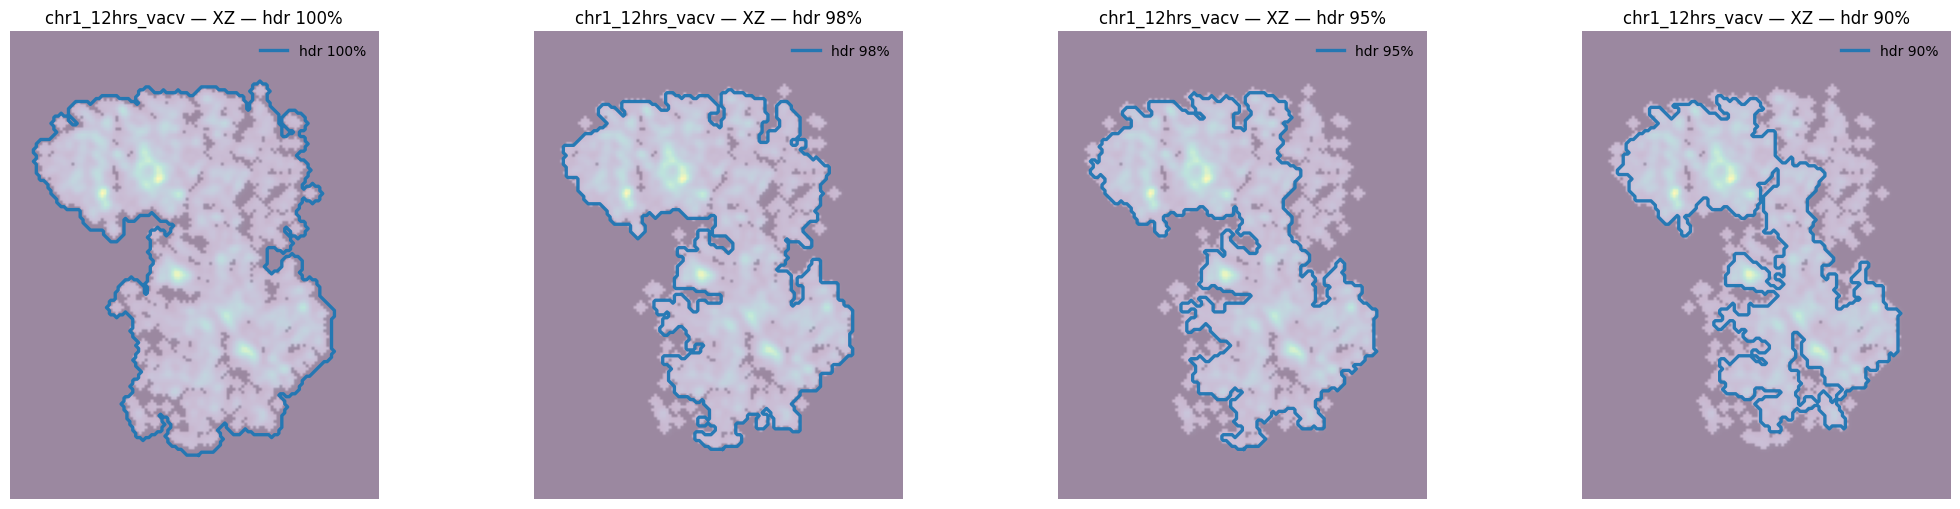

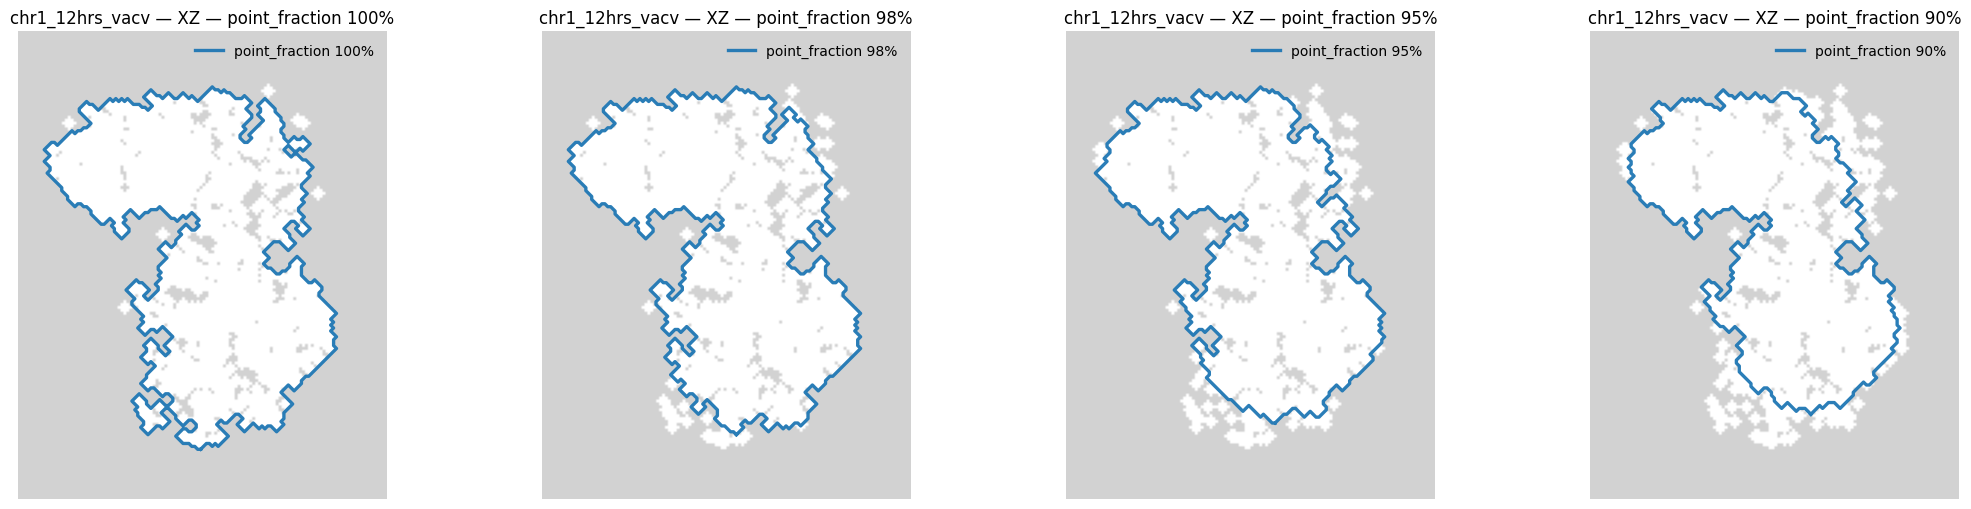

  => chr1_18hrs_untr


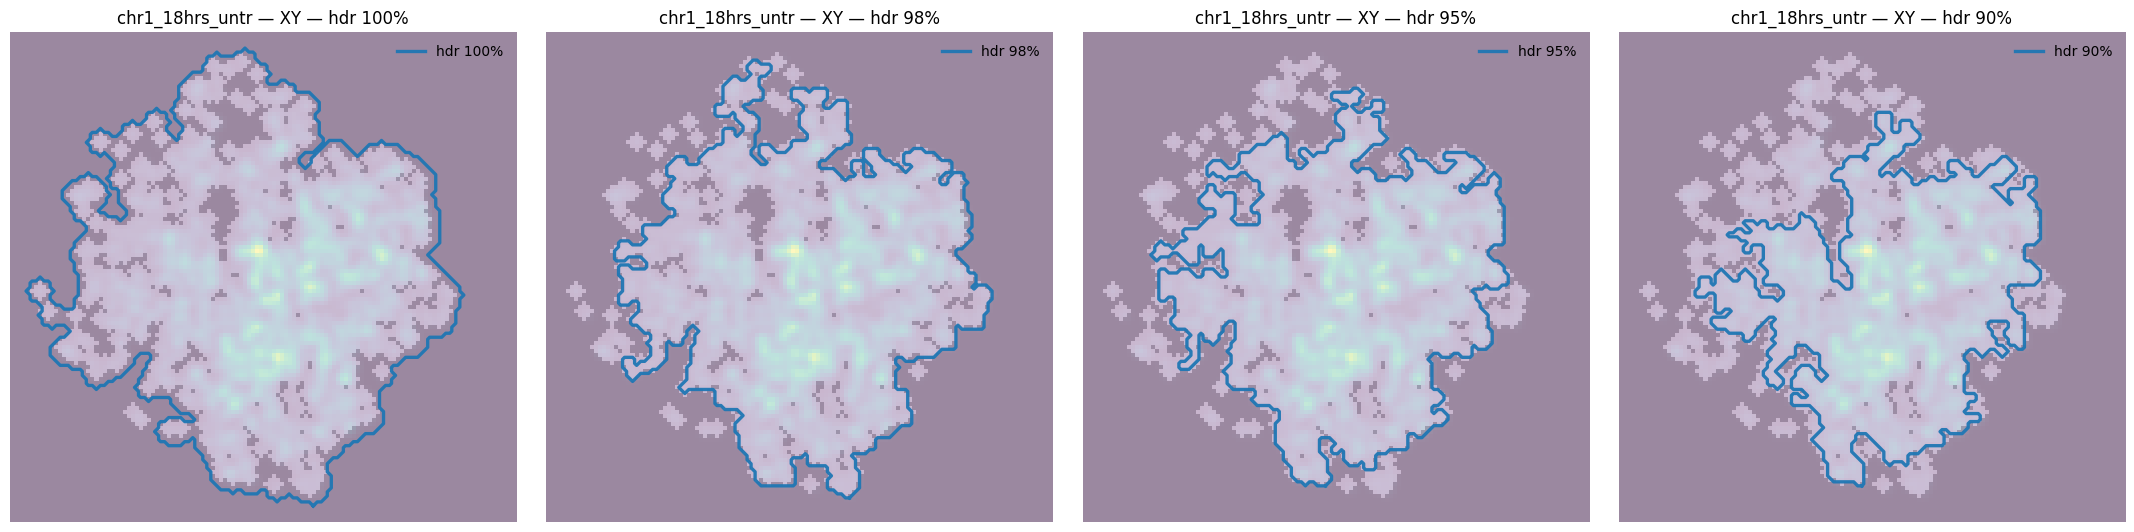

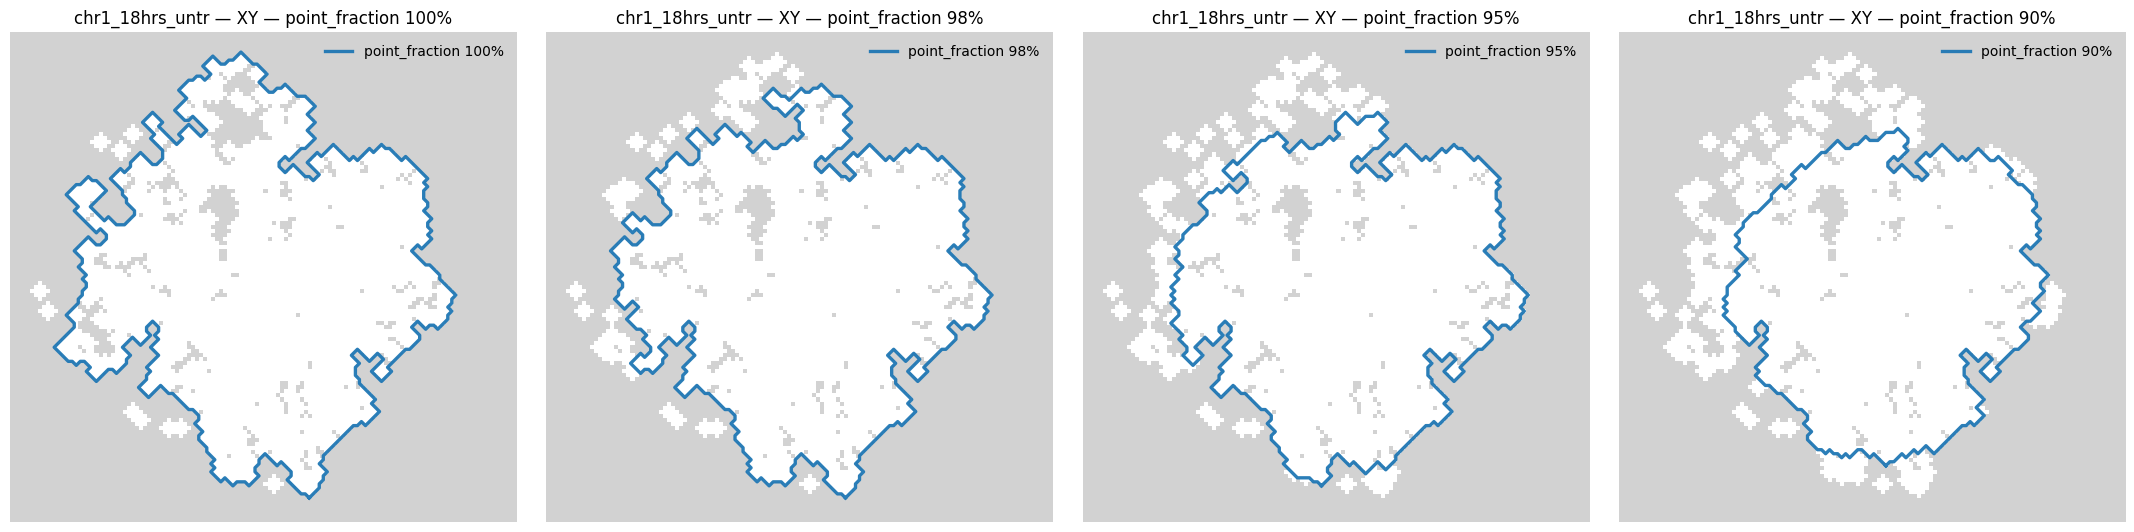

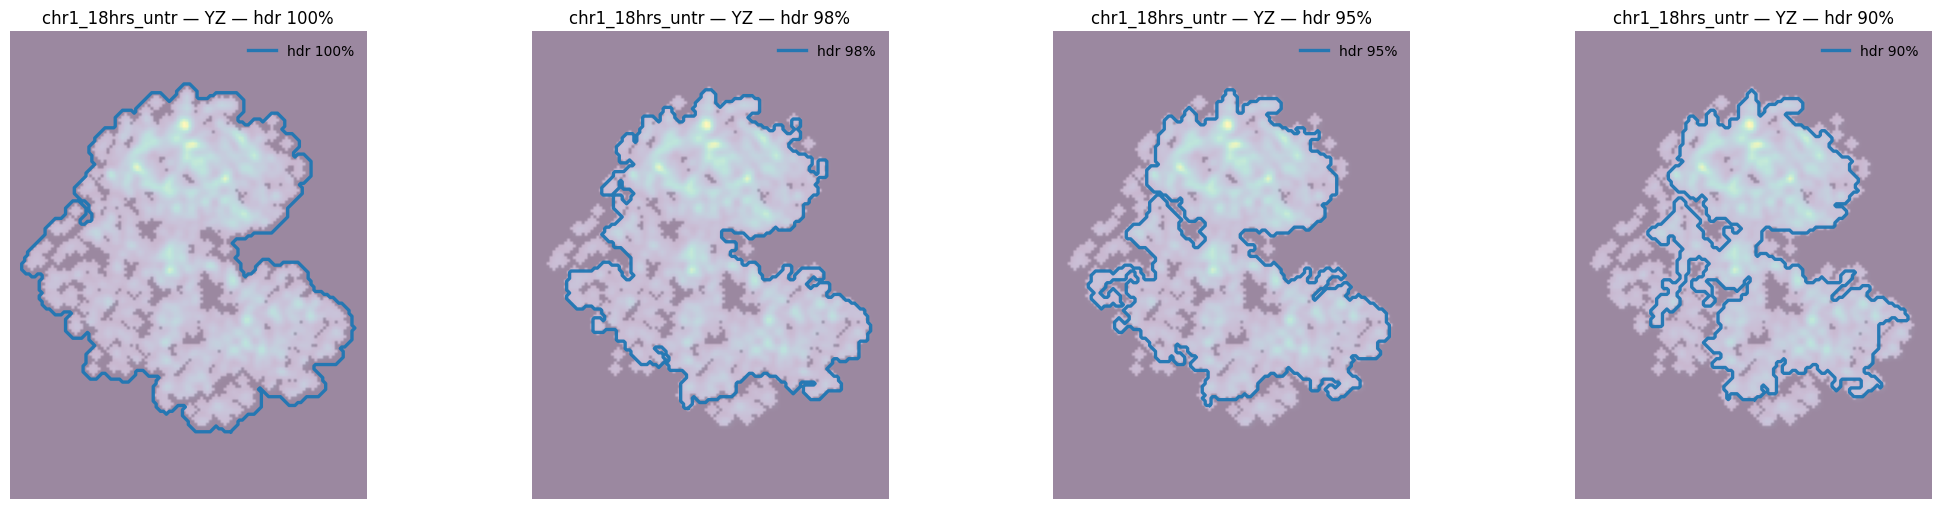

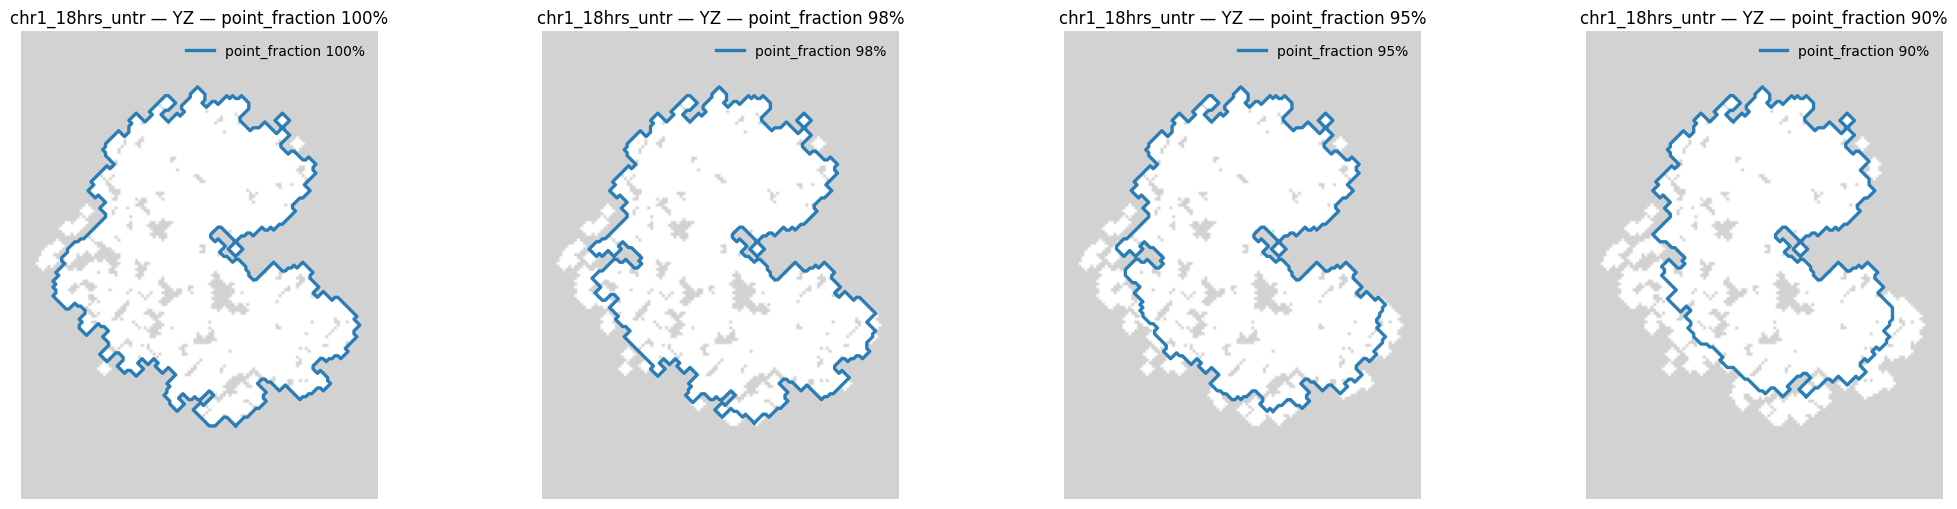

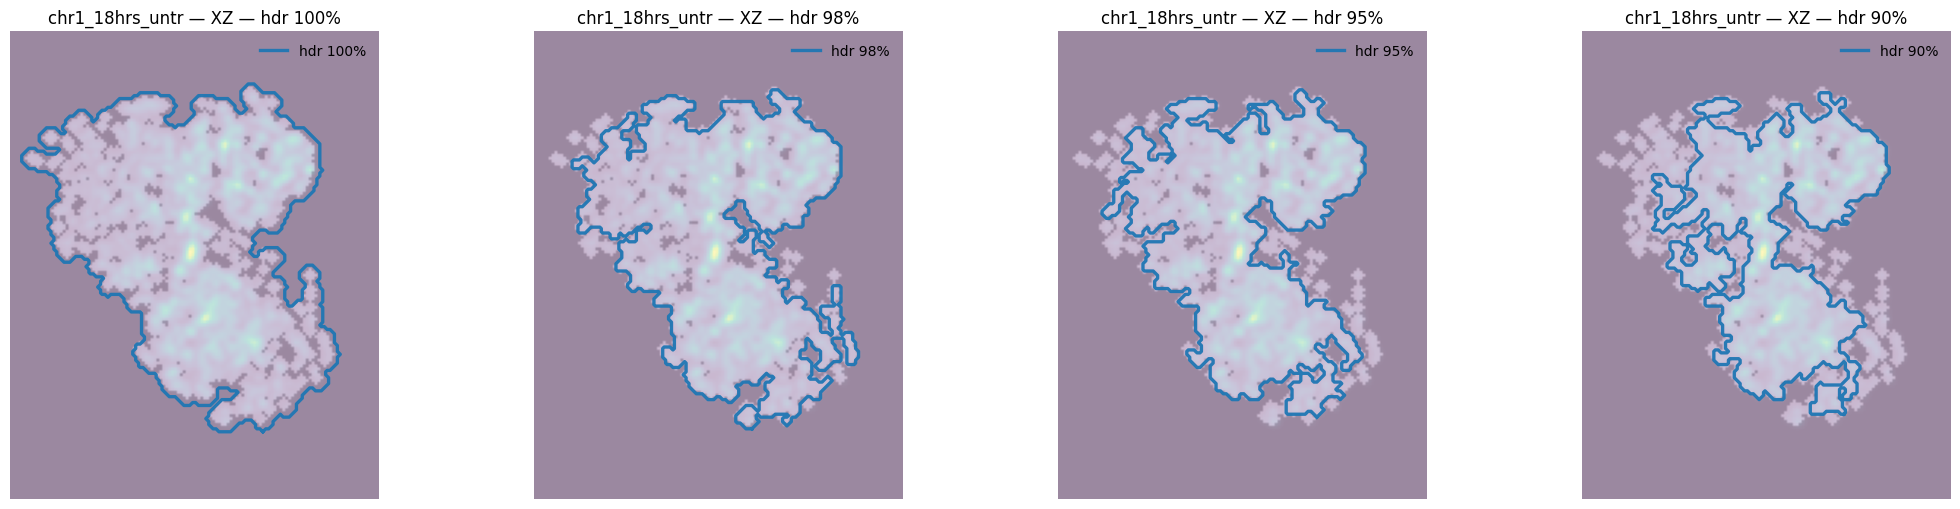

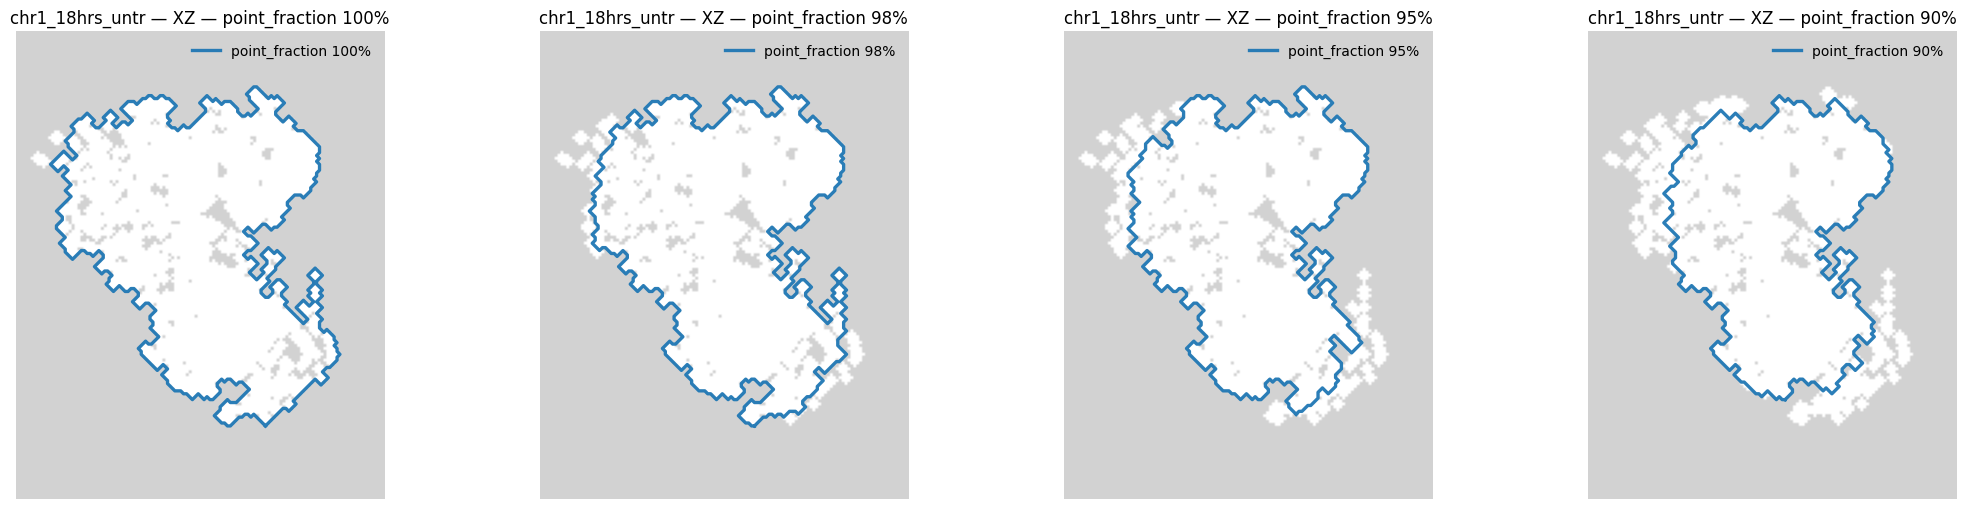

  => chr1_18hrs_vacv


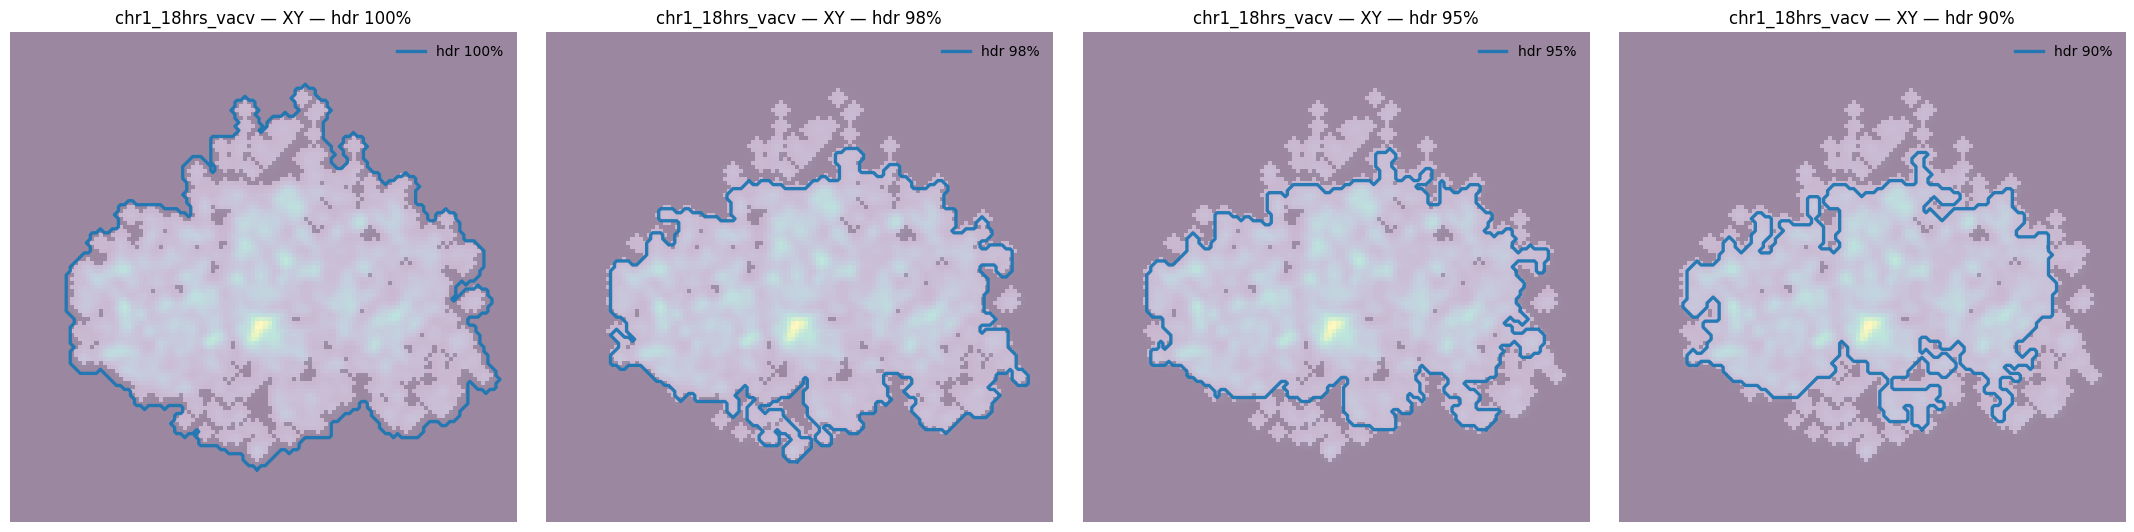

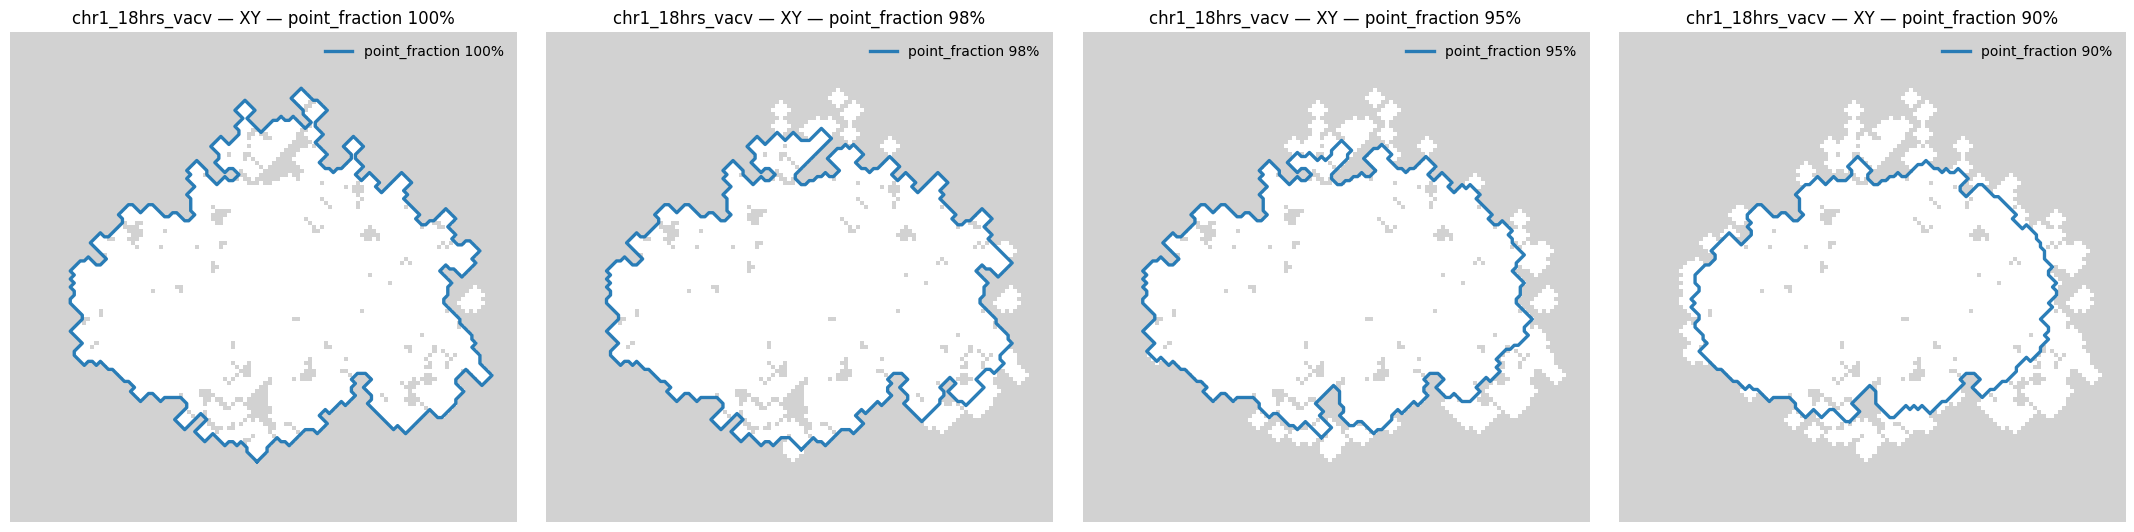

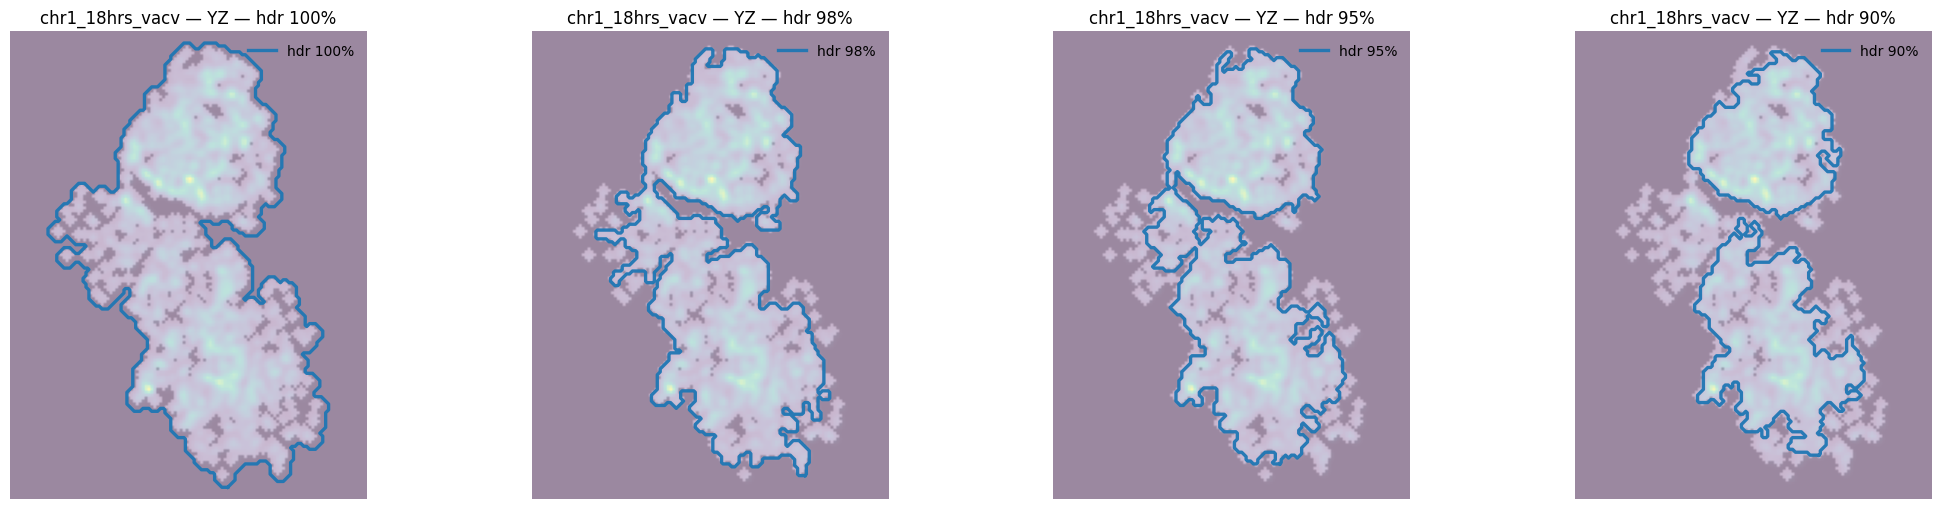

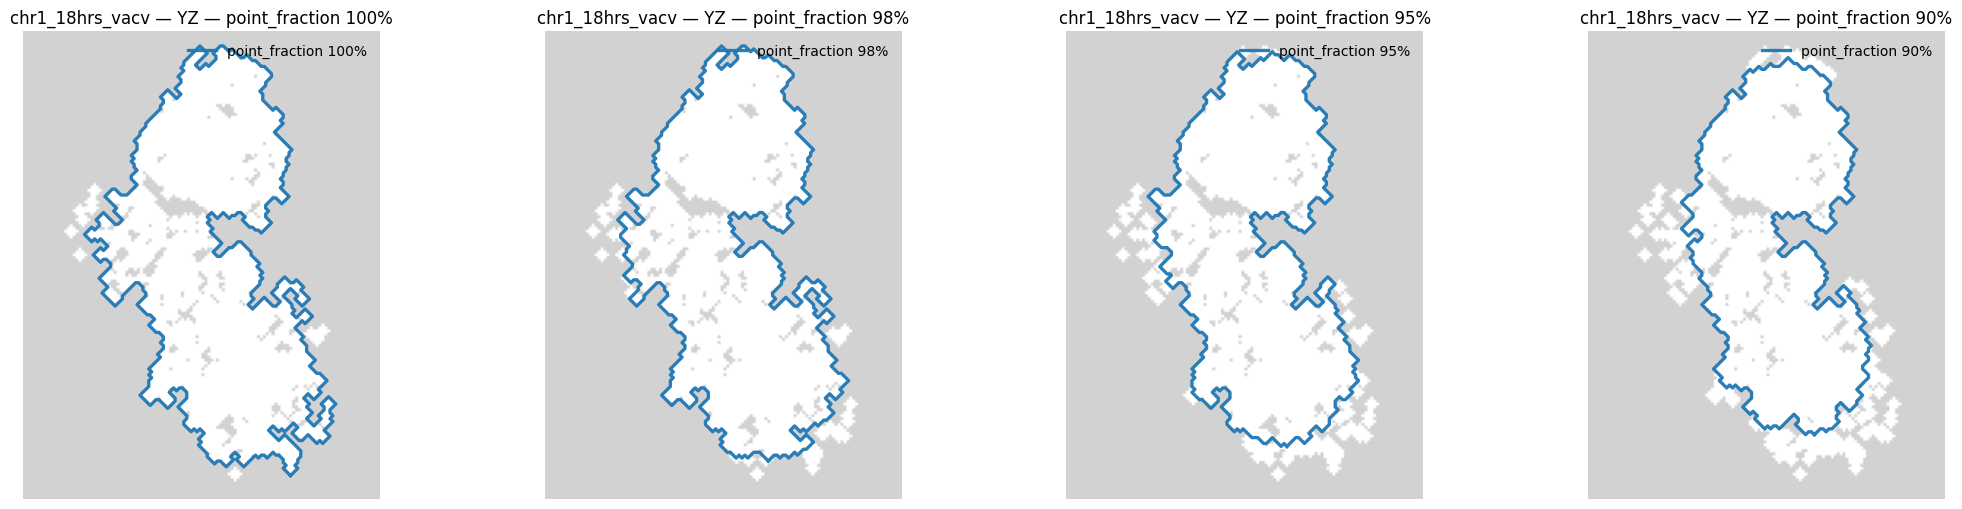

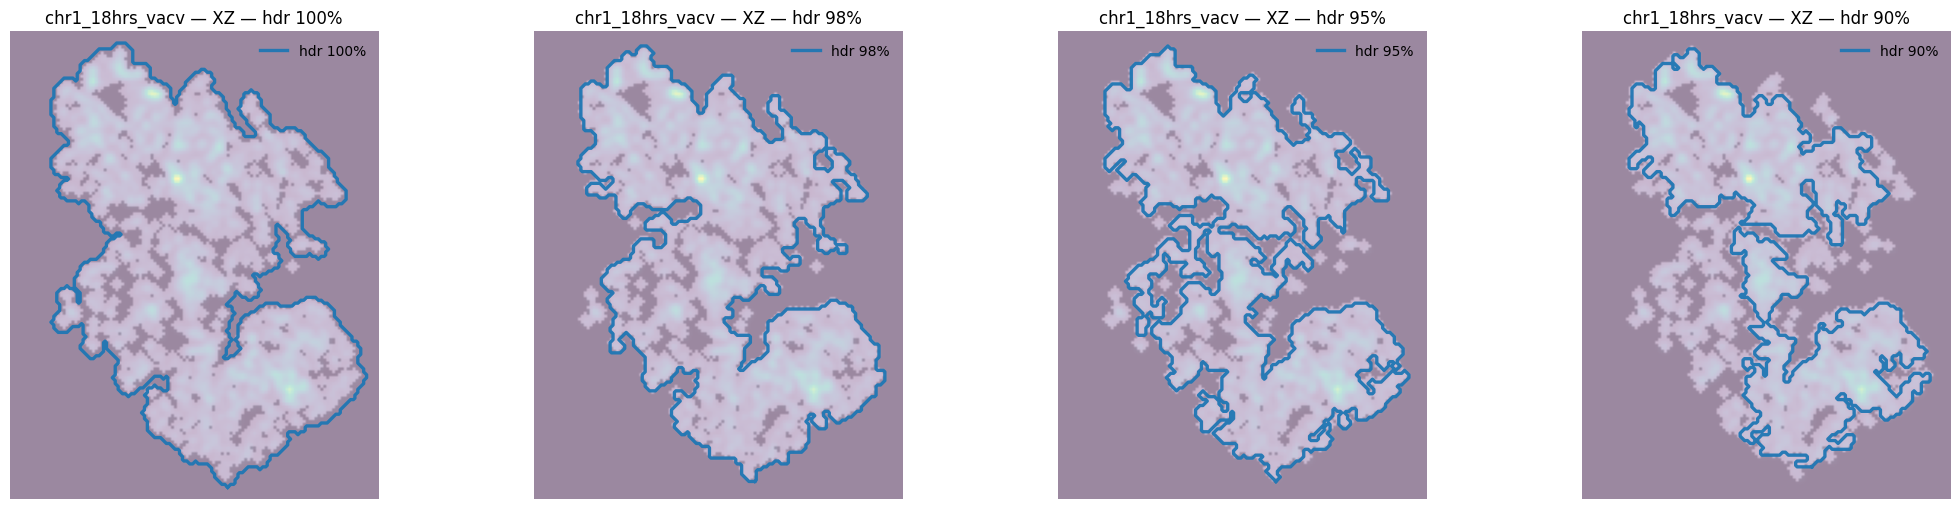

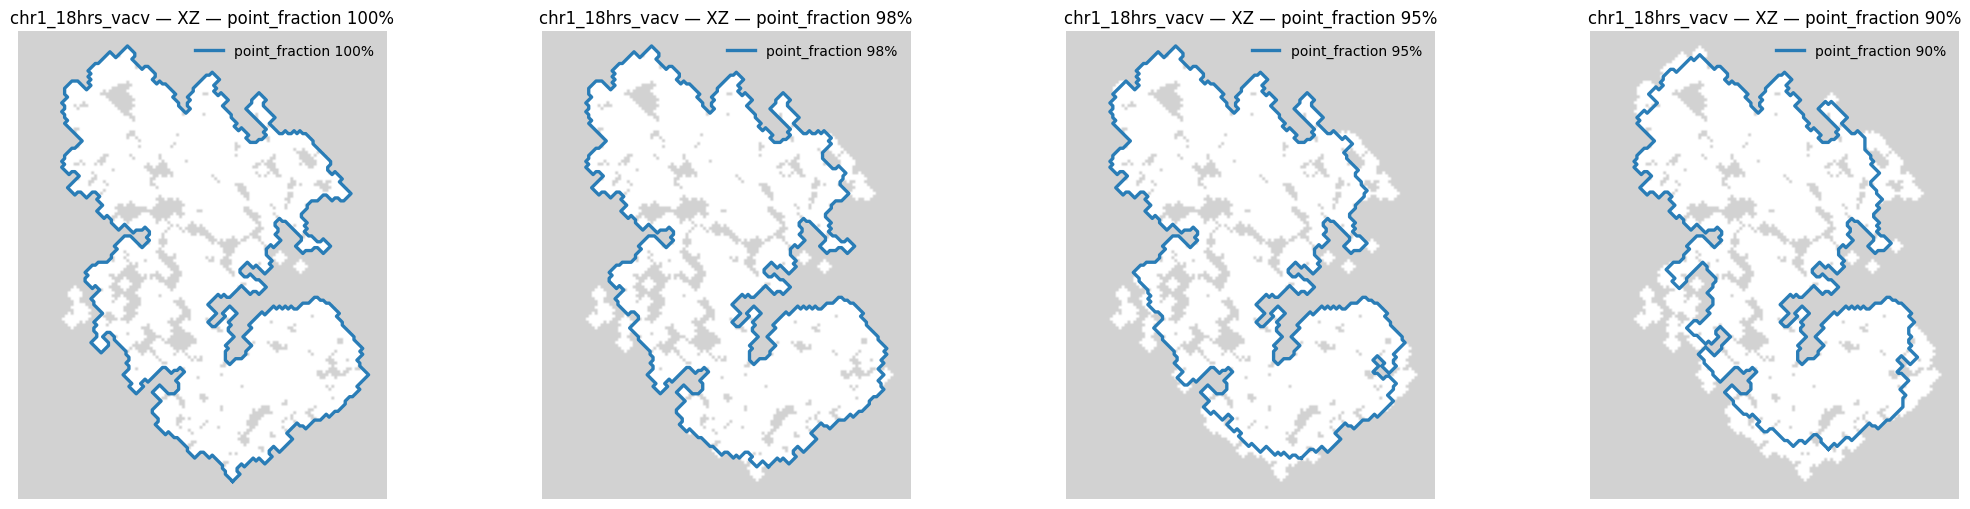

  => chr1_24hrs_untr


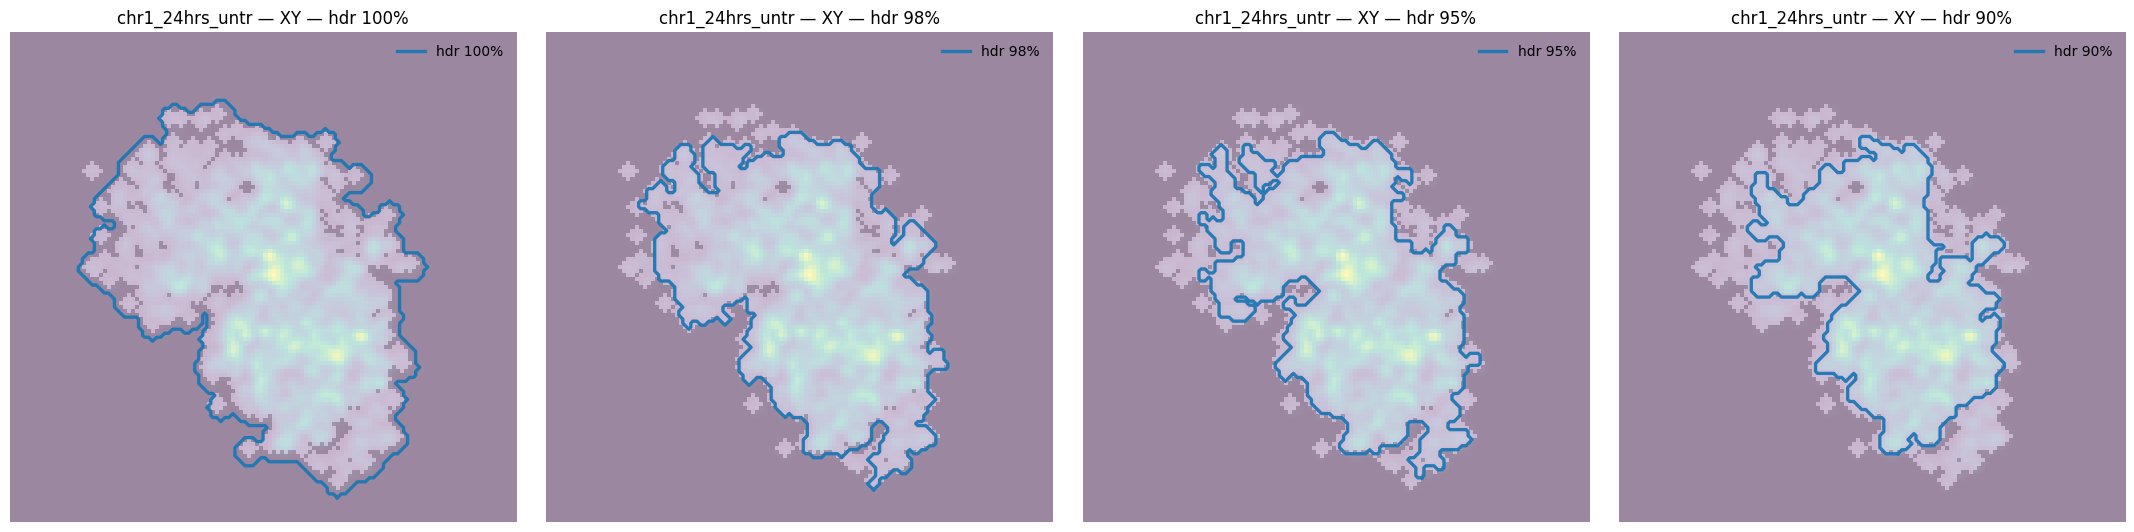

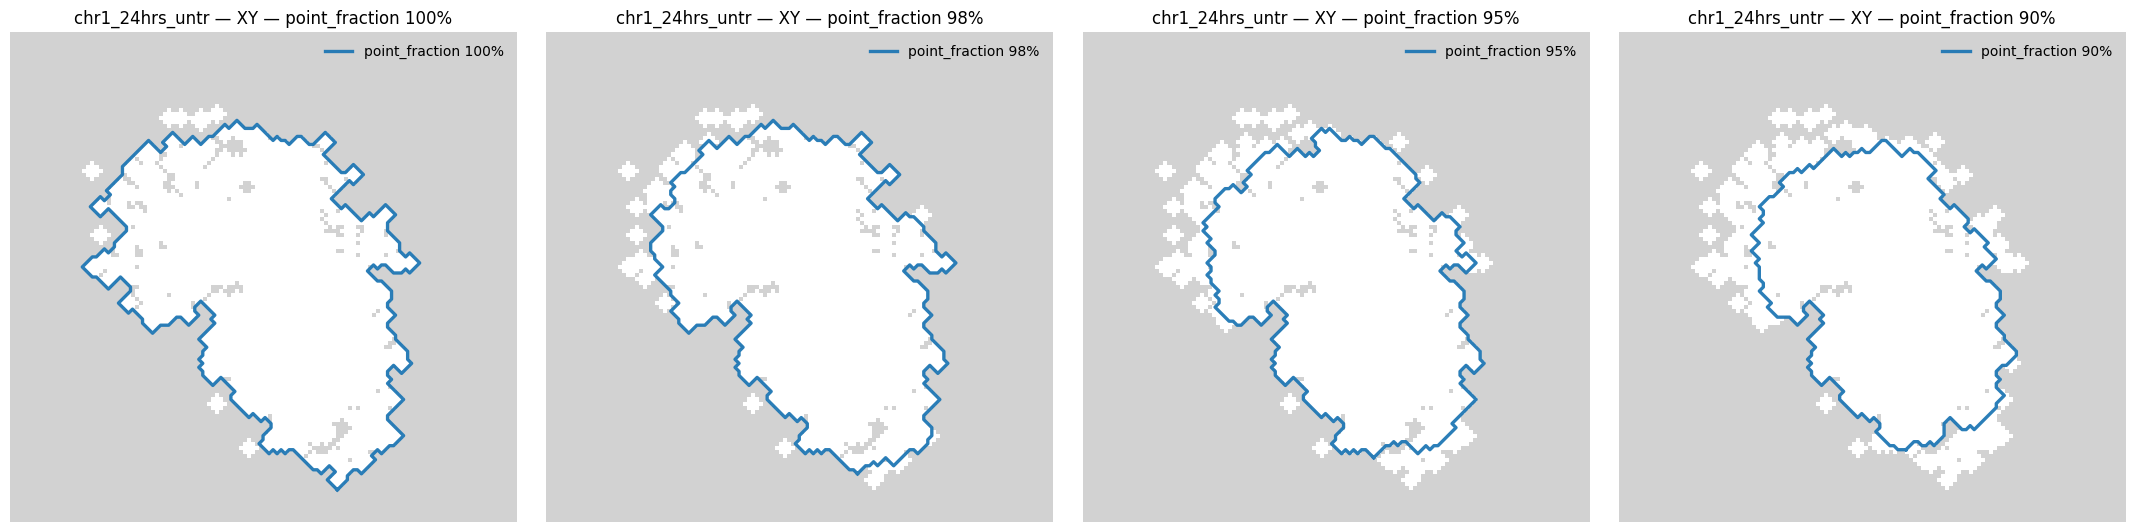

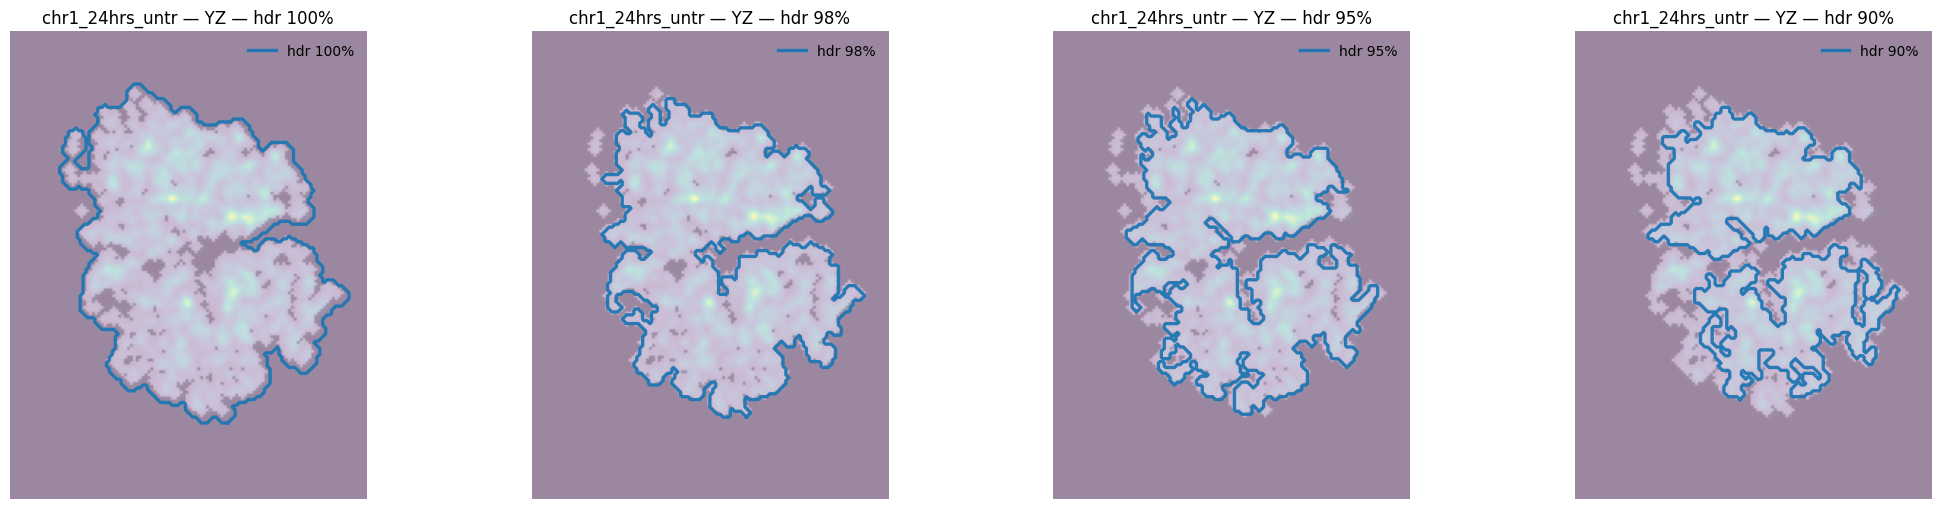

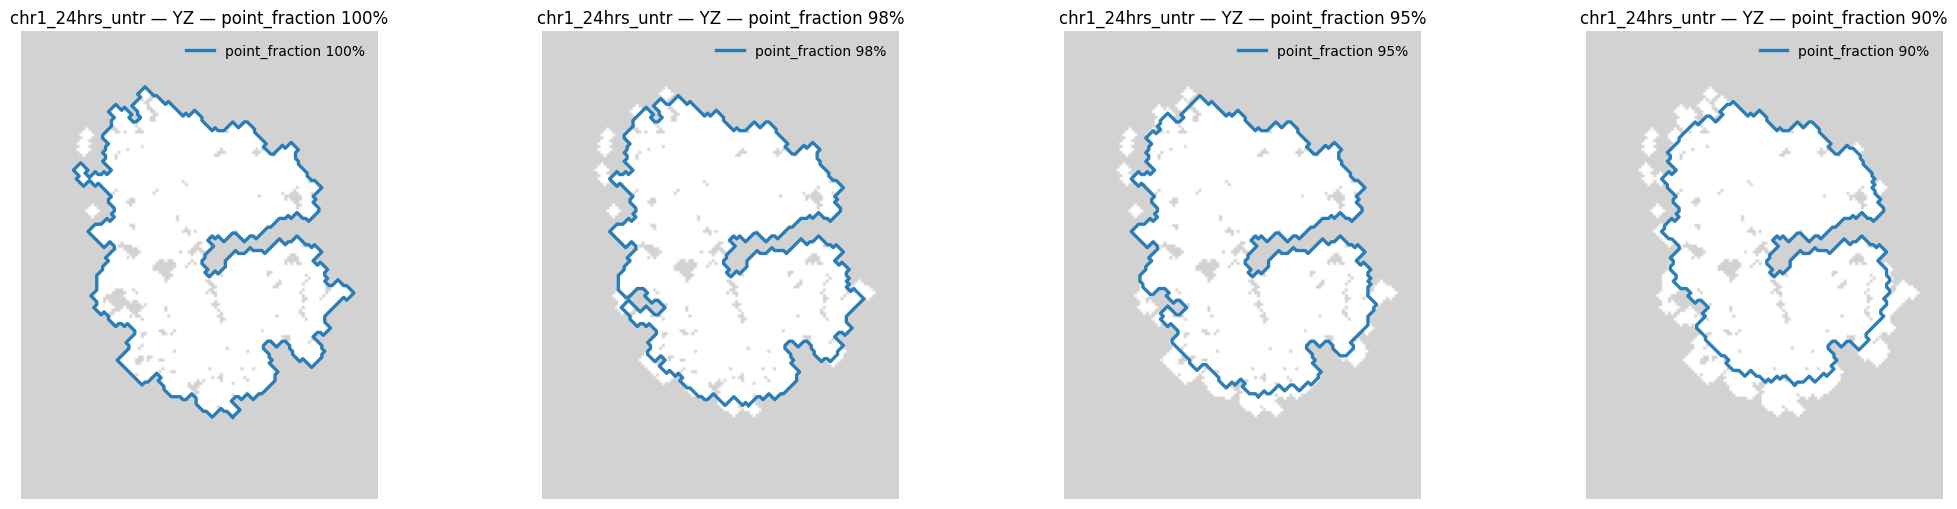

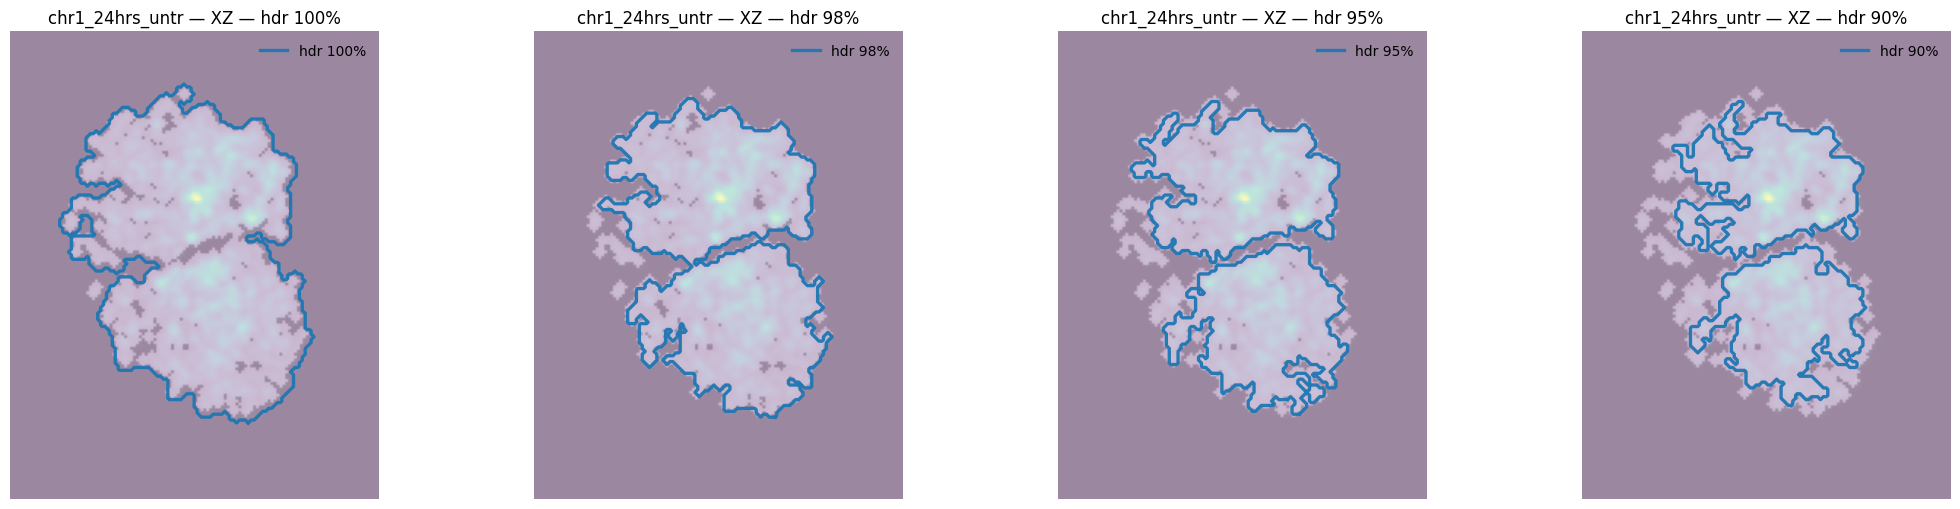

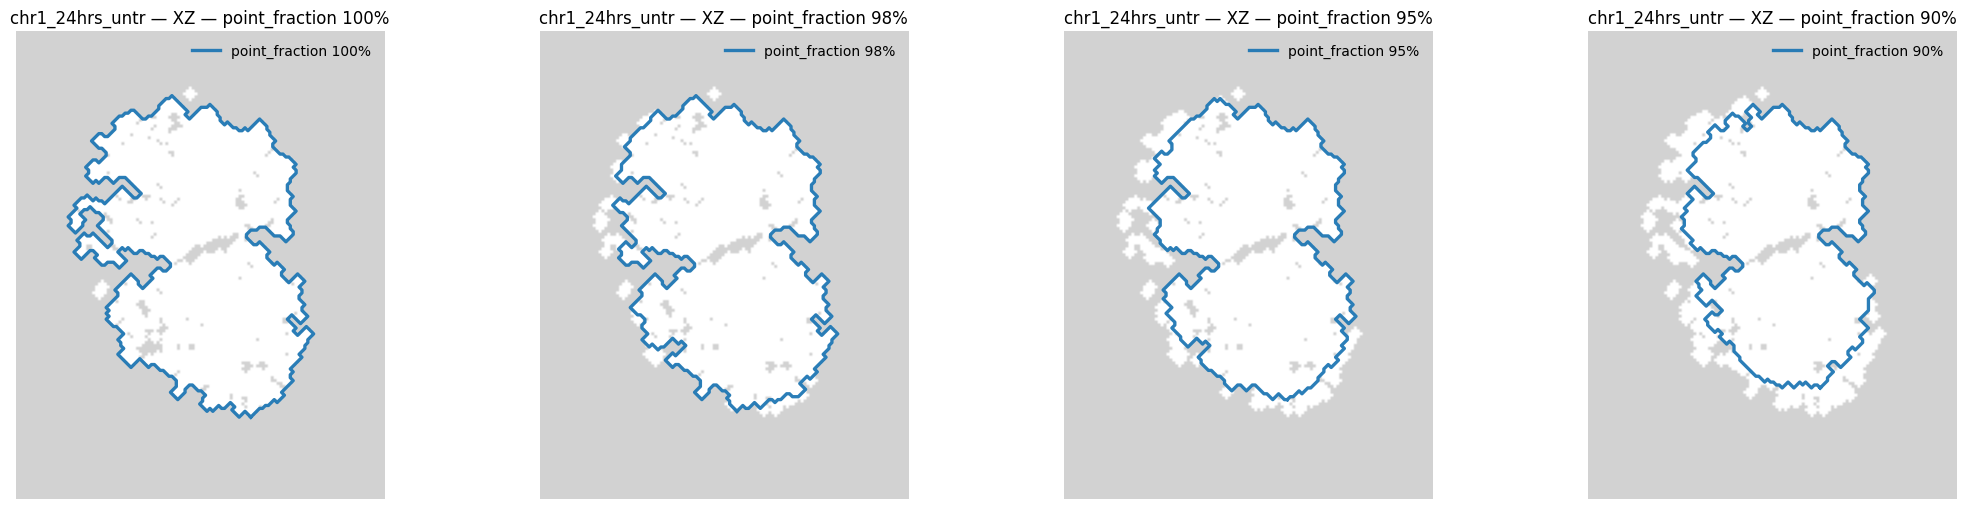

  => chr1_24hrs_vacv


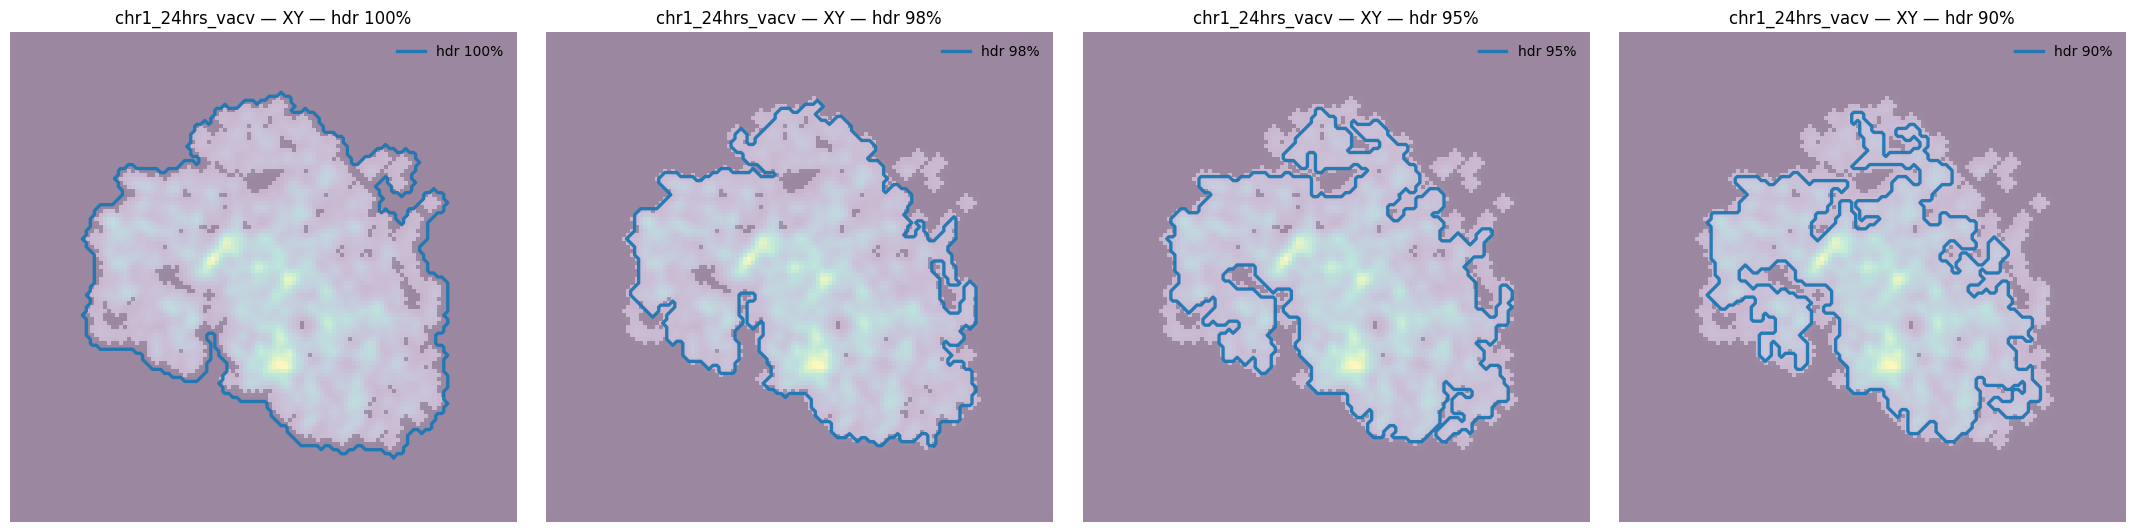

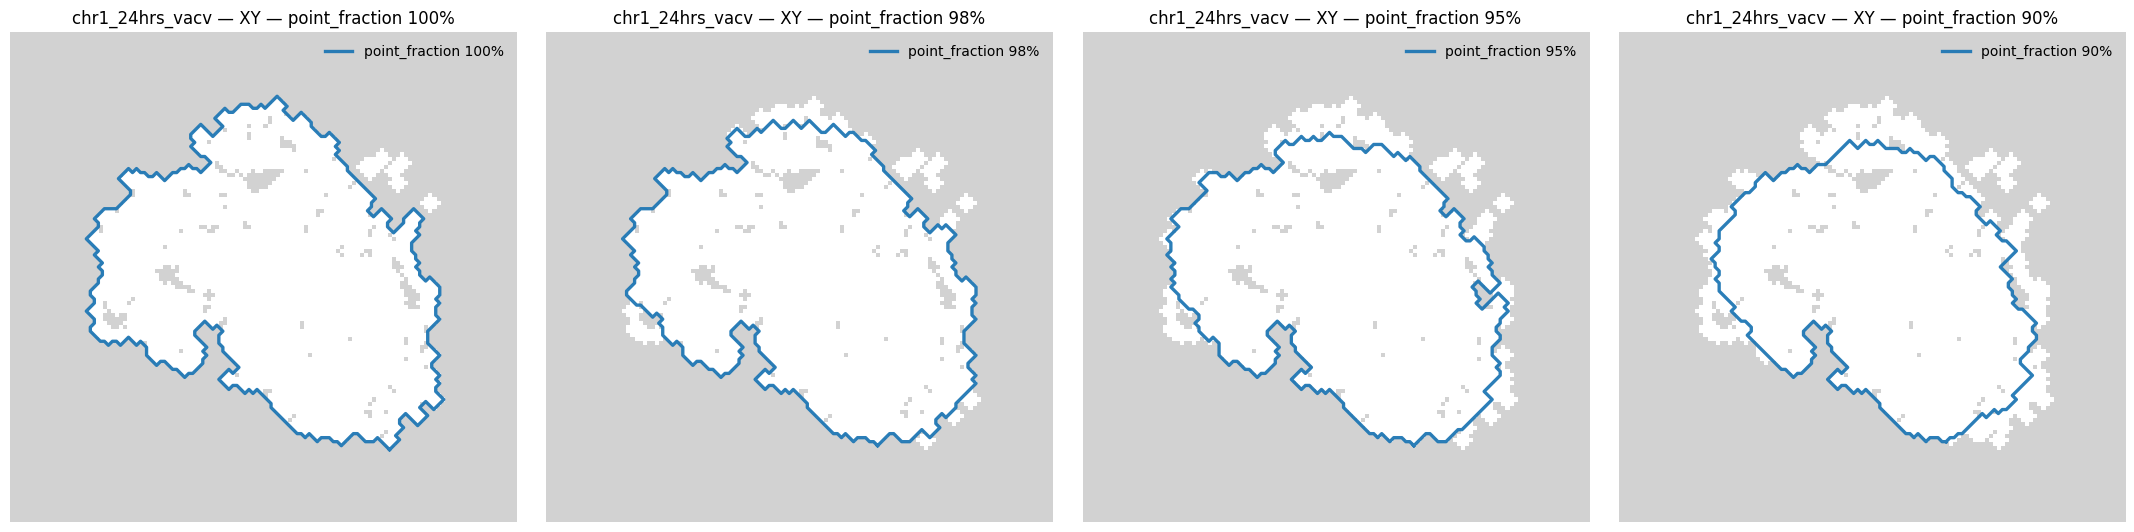

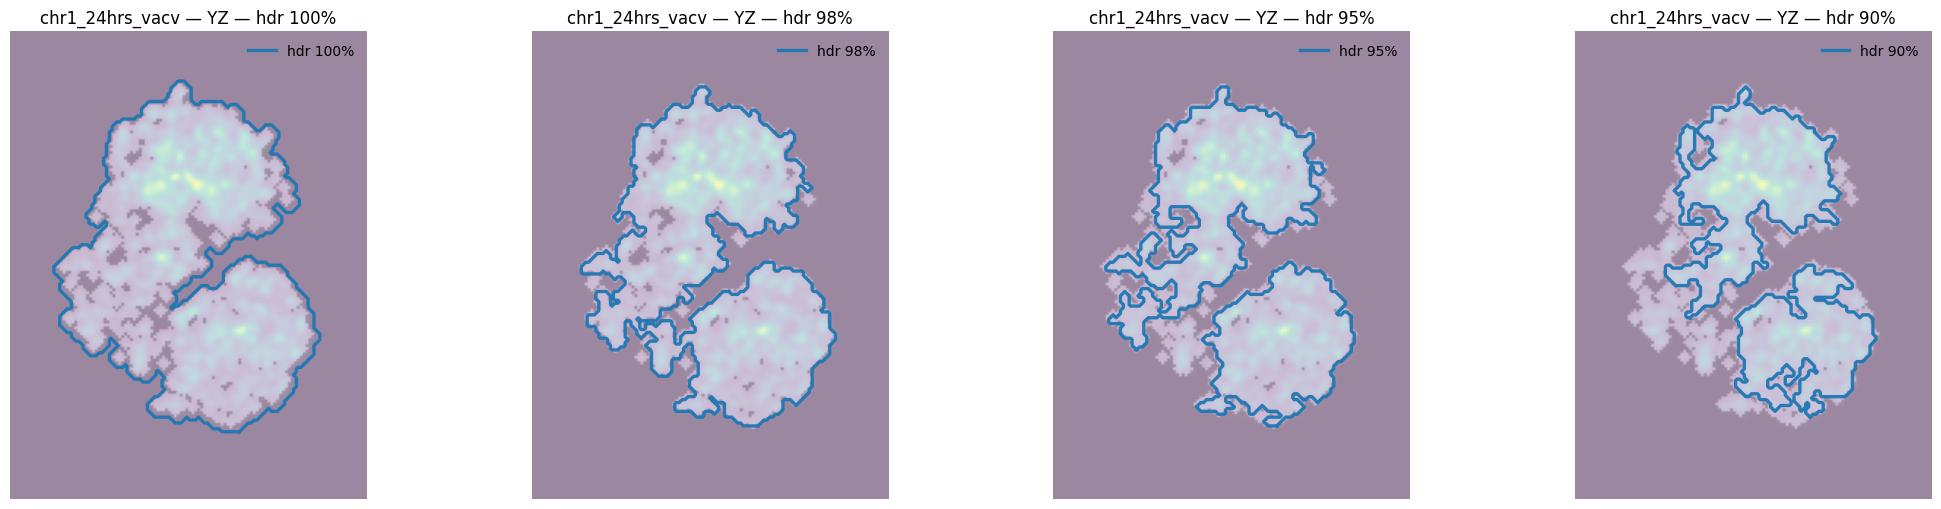

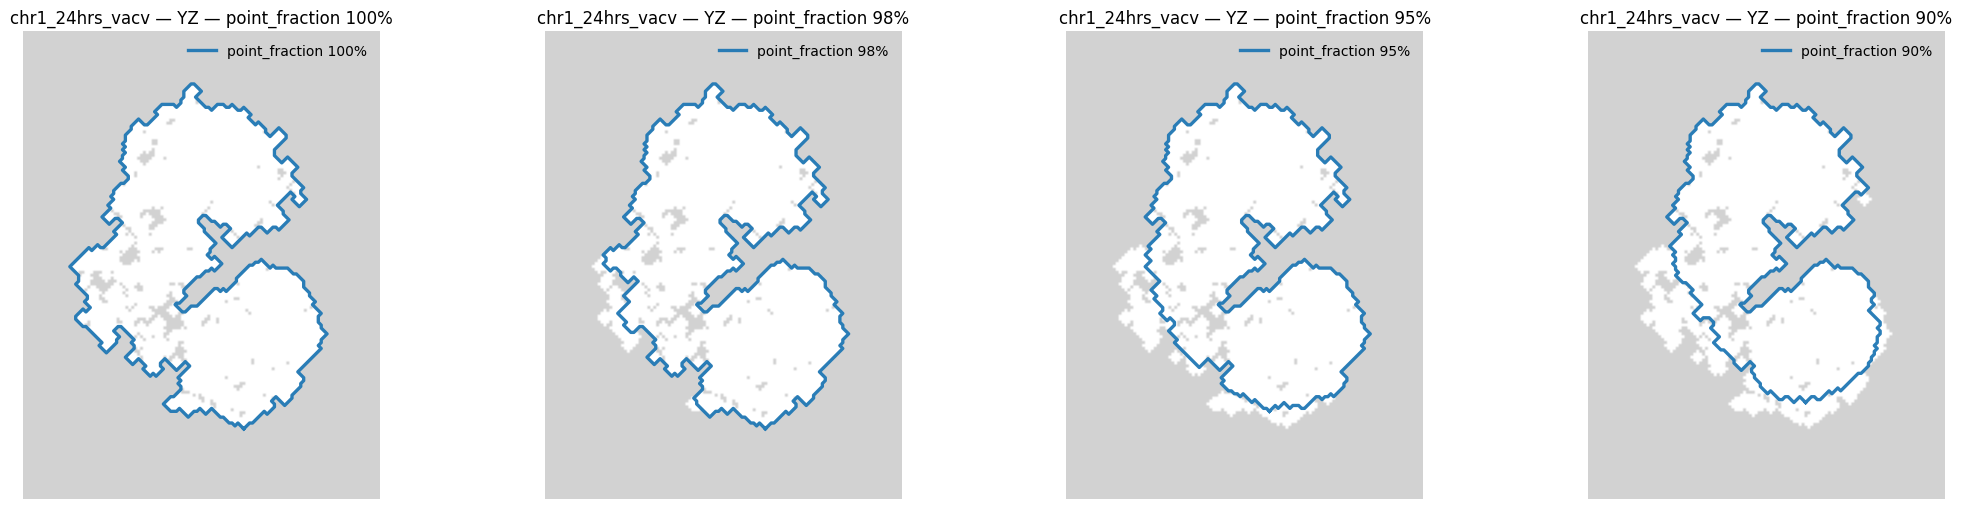

KeyboardInterrupt: 

In [2]:

###### data extraction for web visualization / debug viewing #########

# Base directory containing chromosome folders with structure_*_gene_info.csv files
BASE_DIR = Path("data/green_monkey/all_structure_files")

# NOTE: OUT_ROOT is kept here for reference, but we are NOT saving any
# exported JSON/PNG in this debug script. We only visualize with view_single.
OUT_ROOT = Path("data/green_monkey/shape_data")

# Order for times/conditions when building labels and iteration
TIMES_ORDER = ["12hrs", "18hrs", "24hrs"]
CONDS_ORDER = ["untr", "vacv"]
VALIDCONDS = set(CONDS_ORDER)


def collect_csvs_and_labels(chrom_dir: Path) -> Tuple[List[str], List[str]]:
    """
    Recursively collect all structure_*_gene_info.csv under a chromosome,
    build labels as CHRNAME_TIME_COND using folder names for time/cond.

    Expected layout:
        BASE_DIR/chrX/<time>/<cond>/structure_<time>_<cond>_gene_info.csv

    Example:
        data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv
        => label: "chr1_12hrs_untr"
    """
    chr_name = chrom_dir.name
    csvs: List[Tuple[int, int, Path]] = []  # (time_idx, cond_idx, path)

    for p in chrom_dir.rglob("structure_*_gene_info.csv"):
        # Expect .../<time>/<cond>/structure_<time>_<cond>_gene_info.csv
        # Derive time and cond from folders to be robust.
        if p.parent is None or p.parent.parent is None:
            continue

        cond = p.parent.name.lower()
        time = p.parent.parent.name

        if cond not in VALIDCONDS:
            continue

        # Time ordering: anything not in TIMES_ORDER goes to the end, but kept stable.
        if time not in TIMES_ORDER:
            time_idx = len(TIMES_ORDER)
        else:
            time_idx = TIMES_ORDER.index(time)

        cond_idx = CONDS_ORDER.index(cond)
        csvs.append((time_idx, cond_idx, p))

    # Sort by (time, cond, path) for reproducible ordering across runs
    csvs.sort(key=lambda t: (t[0], t[1], str(t[2])))

    csv_list: List[str] = []
    labels: List[str] = []
    for _, _, path in csvs:
        time = path.parent.parent.name
        cond = path.parent.name.lower()
        label = f"{chr_name}_{time}_{cond.lower()}"
        csv_list.append(str(path))
        labels.append(label)

    return csv_list, labels


def main():
    # We keep OUT_ROOT just to ensure the parent exists, in case downstream
    # tooling assumes the folder is present, but we are not saving any files here.
    OUT_ROOT.mkdir(parents=True, exist_ok=True)

    chrom_dirs = [d for d in BASE_DIR.iterdir() if d.is_dir()]
    if not chrom_dirs:
        print(f"[WARN] No chromosome folders in {BASE_DIR}")
        return

    done, skipped, failed = 0, 0, 0
    t_total_start = time.time()   # <= TOTAL START

    for chrom_dir in sorted(chrom_dirs, key=lambda p: p.name):
        chr_name = chrom_dir.name
        print(f"\n=== {chr_name} ===")

        csv_list, labels = collect_csvs_and_labels(chrom_dir)
        if len(csv_list) < 2:
            print(f"[SKIP] Found {len(csv_list)} file(s) under {chr_name}; need ≥2 to run.")
            skipped += 1
            continue

        # NOTE: out_dir is not used for saving in this debug script.
        out_dir = OUT_ROOT / chr_name
        out_dir.mkdir(parents=True, exist_ok=True)

        try:
            # --------------------------------------------------------------
            # Build configs for this chromosome.
            #   - CfgCommon: grid_base/pad_frac control the 2D grids.
            #   - CfgHDR:    controls HDR levels and density behavior.
            #   - CfgPF:     controls point-fraction levels and morphology.
            # --------------------------------------------------------------
            cfg_common = CfgCommon(
                grid_base=160,
                pad_frac=0.05,
            )
            cfg_hdr = CfgHDR()
            cfg_pf = CfgPF(
                morph=CfgMorph(
                    closing=1,
                    opening=1,
                    keep_largest=False,
                    fill_holes=True
                )
            )

            print(f"[RUN] {chr_name}: {len(csv_list)} CSVs")

            t_chr_start = time.time()   # <= PER-CHR START

            # Run the MPASE pipeline:
            #   - alignment (PCA + ICP),
            #   - per-plane grids and densities,
            #   - HDR and point-fraction silhouettes for all configured levels.
            result = mpase(
                csv_list=csv_list,
                labels=labels,
                cfg_common=cfg_common,
                cfg_hdr=cfg_hdr,
                cfg_pf=cfg_pf,
            )

            t_chr_end = time.time()     # <= PER-CHR END
            elapsed_chr = t_chr_end - t_chr_start

            # --------------------------------------------------------------
            # VISUAL CHECK ONLY (NO EXPORTING)
            #
            # For each label (time/cond combination) in this chromosome:
            #   - View HDR  silhouettes at 100 / 98 / 95 / 90 for each plane.
            #   - View PF   silhouettes at 100 / 98 / 95 / 90 for each plane.
            #
            # We use view_single(...) so each call shows a single label with
            # optional density heat for HDR (to verify all points lie inside).
            # --------------------------------------------------------------
            levels_to_view = [100, 98, 95, 90]
            planes_to_view = ("XY", "YZ", "XZ")

            print(f"[VIEW] {chr_name}: levels={levels_to_view}, planes={planes_to_view}")
            for lab in labels:
                print(f"  => {lab}")
                for plane in planes_to_view:
                    # HDR with density heat as context
                    view_single(
                        result,
                        label=lab,
                        kind="hdr",
                        plane=plane,
                        levels=levels_to_view,
                        show_heat=True,   # show density under HDR contours
                        cfg_hdr=cfg_hdr,
                        cfg_pf=cfg_pf,clean_blobs=True, blob_min_area_frac=0.08, blob_min_len=15
                    )

                    # Point-fraction (PF) silhouettes (no density heat)
                    view_single(
                        result,
                        label=lab,
                        kind="point_fraction",
                        plane=plane,
                        levels=levels_to_view,
                        show_heat=False,
                        cfg_hdr=cfg_hdr,
                        cfg_pf=cfg_pf, clean_blobs=True, blob_min_area_frac=0.08, blob_min_len=15
                    )

            print("=" * 25)
            print(f"[OK] Viewed => {chr_name}")
            print(f" [TIME] Elapsed Time => ({elapsed_chr:.1f} s)")
            print("=" * 25)
            done += 1

        except Exception as e:
            failed += 1
            print(f"[FAIL] {chr_name}: {e}")
            traceback.print_exc()

    t_total_end = time.time()           # <= TOTAL END
    elapsed_total = t_total_end - t_total_start

    print("\n=== Summary ===")
    print(f"Completed (viewed): {done}")
    print(f"Skipped:            {skipped}")
    print(f"Failures:           {failed}")
    print("=" * 25)
    print(f"Total time: {elapsed_total/60:.2f} min ({elapsed_total:.1f} s)")
    print("=" * 25)


if __name__ == "__main__":
    main()
